+proj=longlat +datum=NAD83 +no_defs


./AI4DICensus.ipynb:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  "cells": [


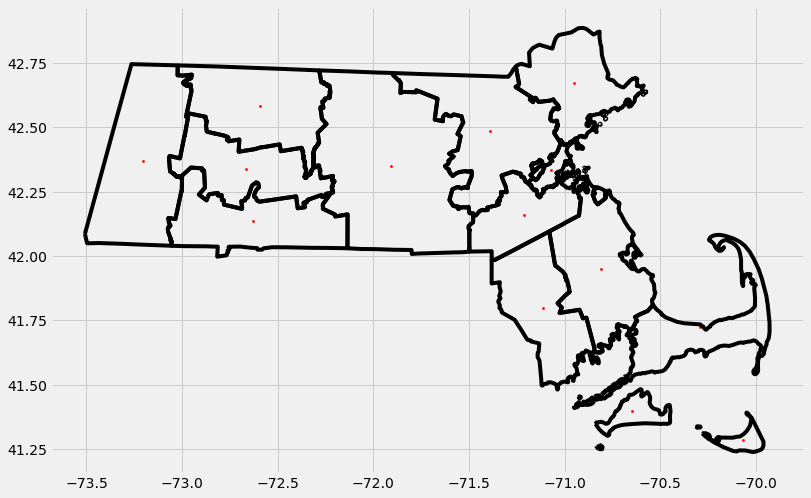

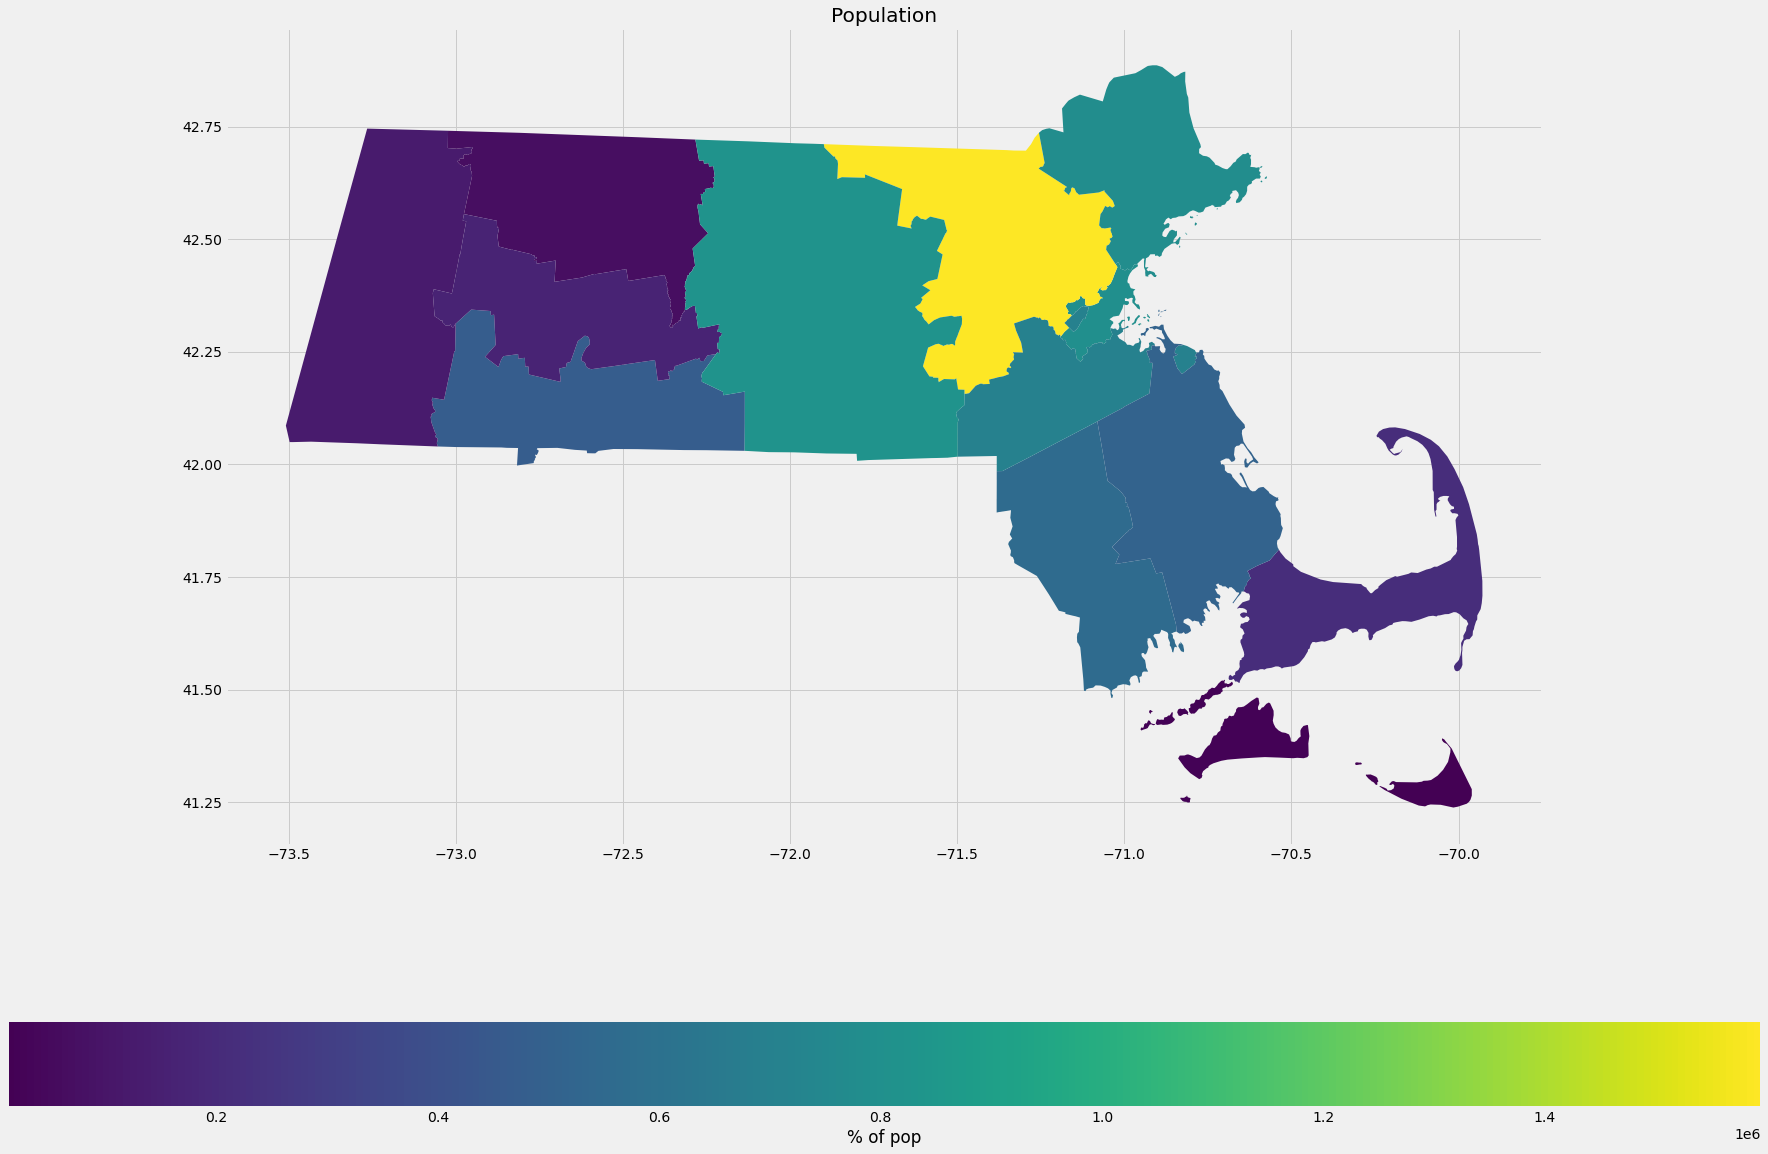

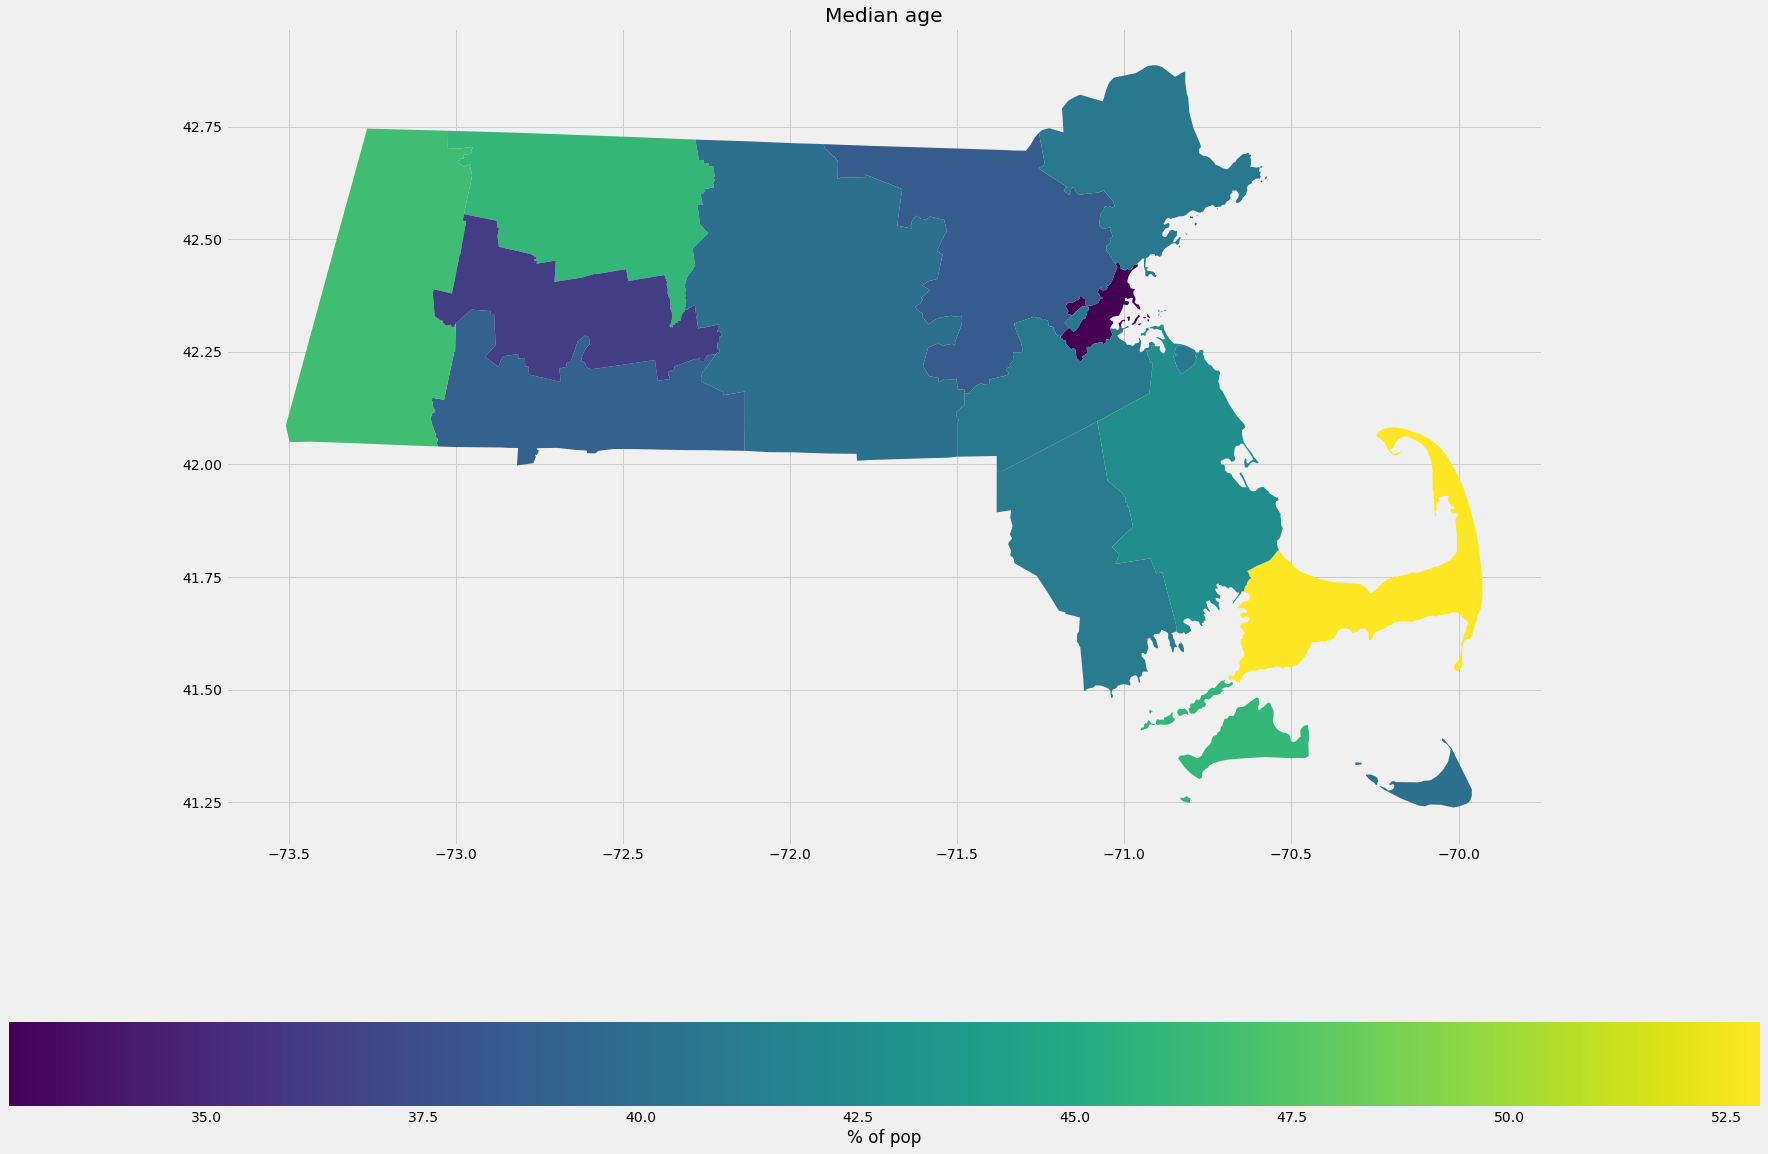

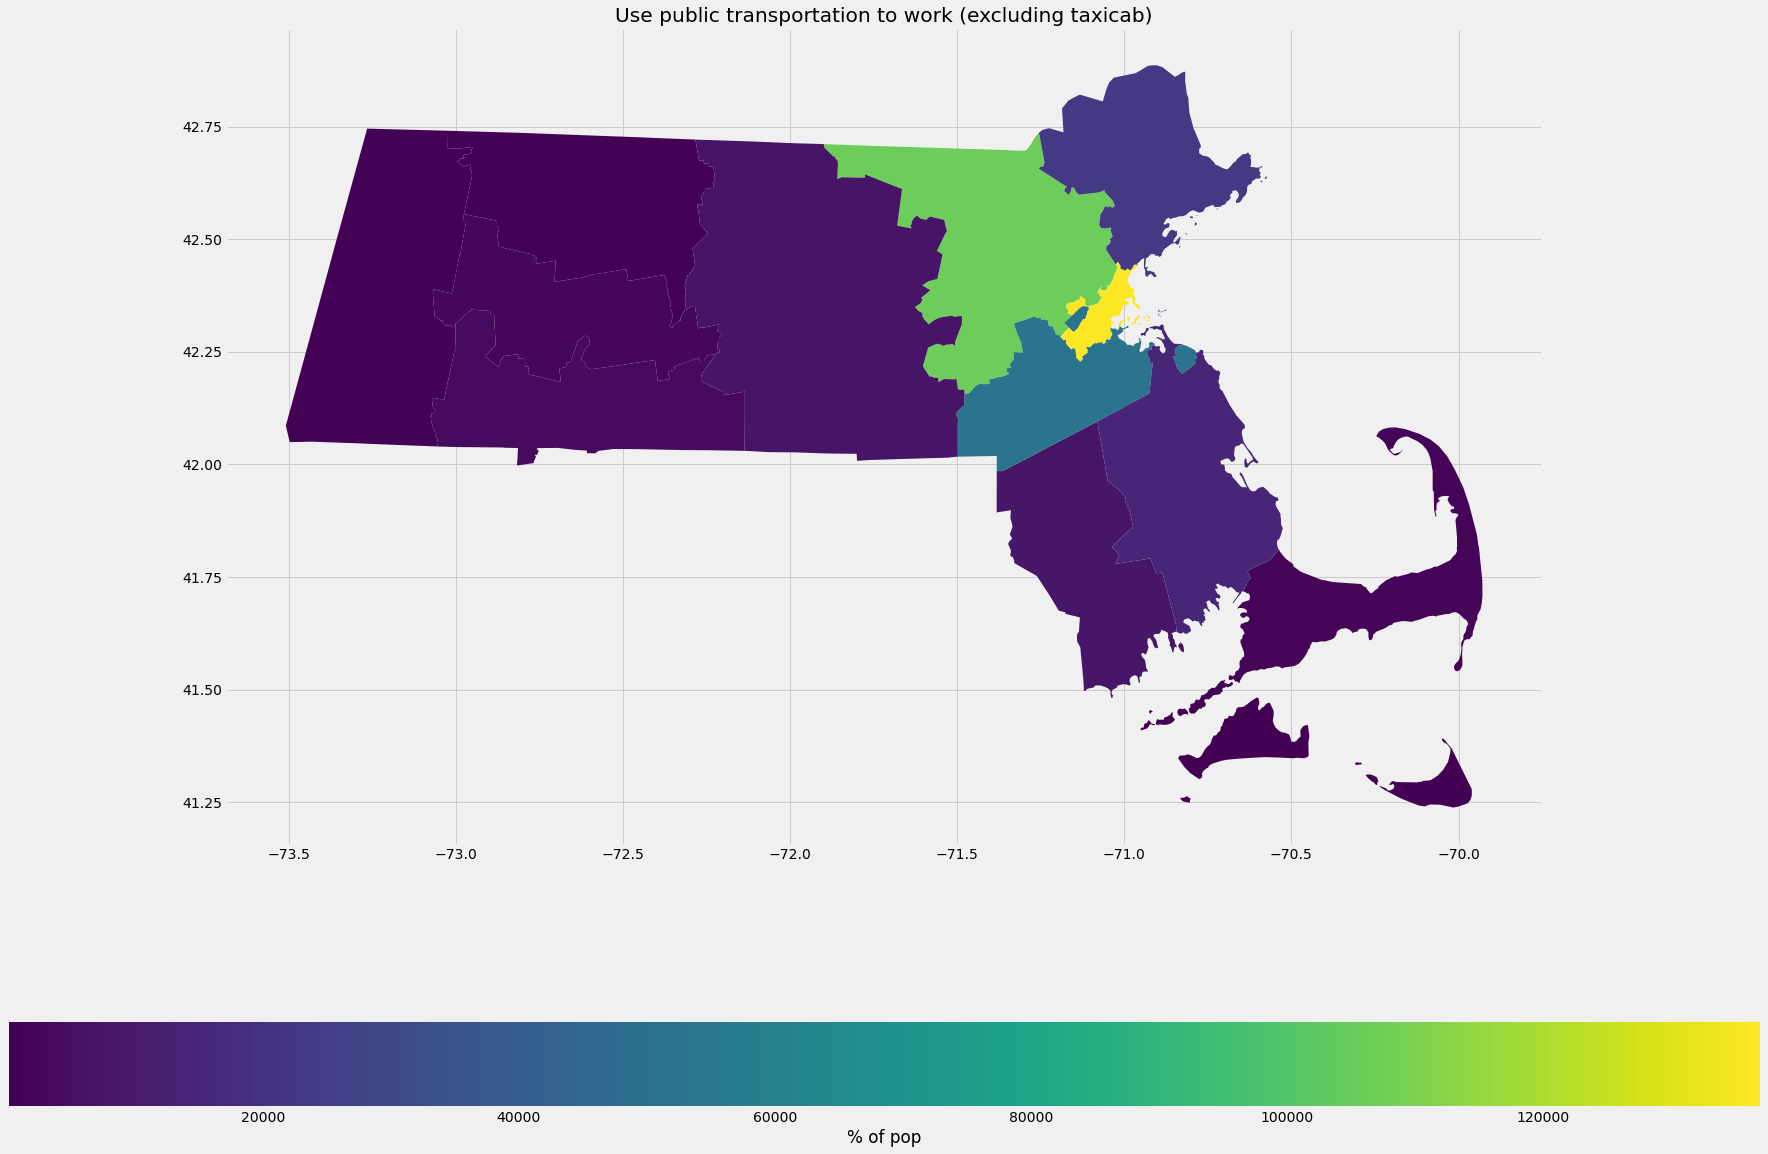

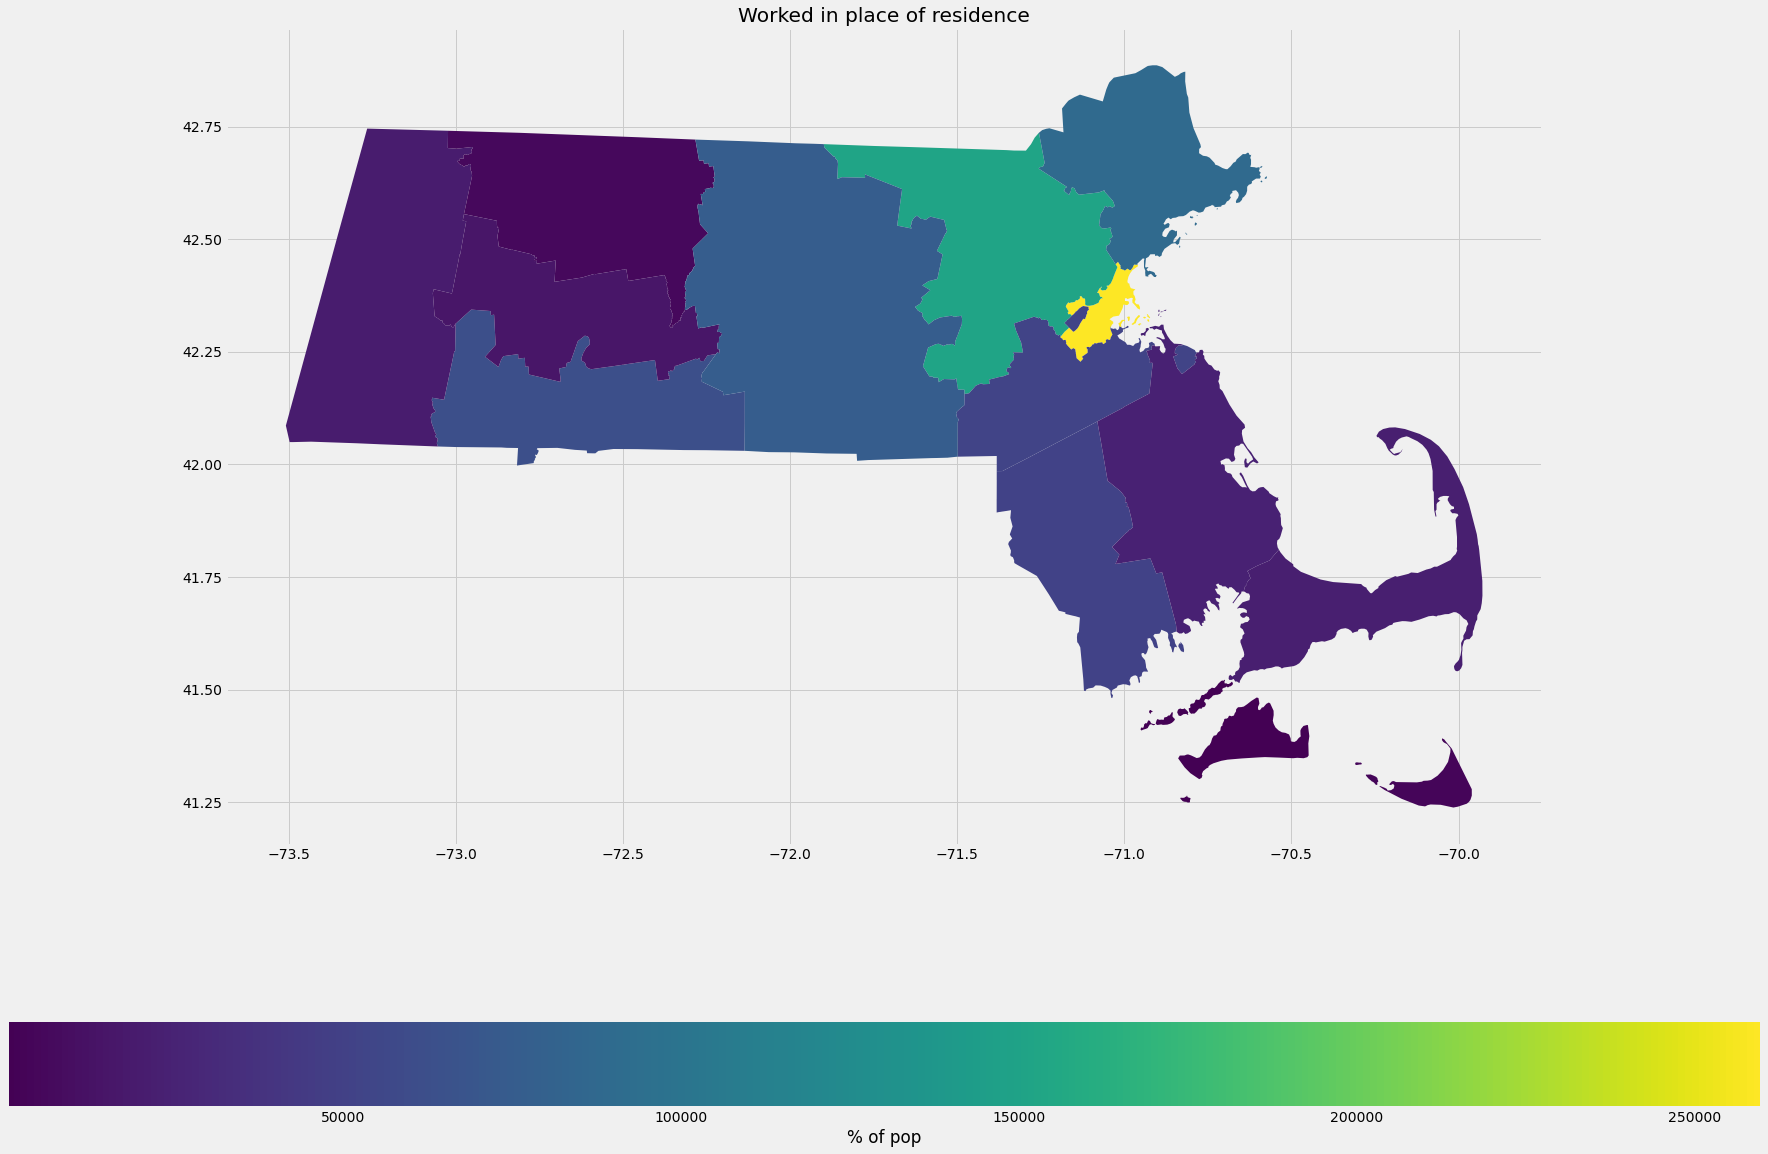

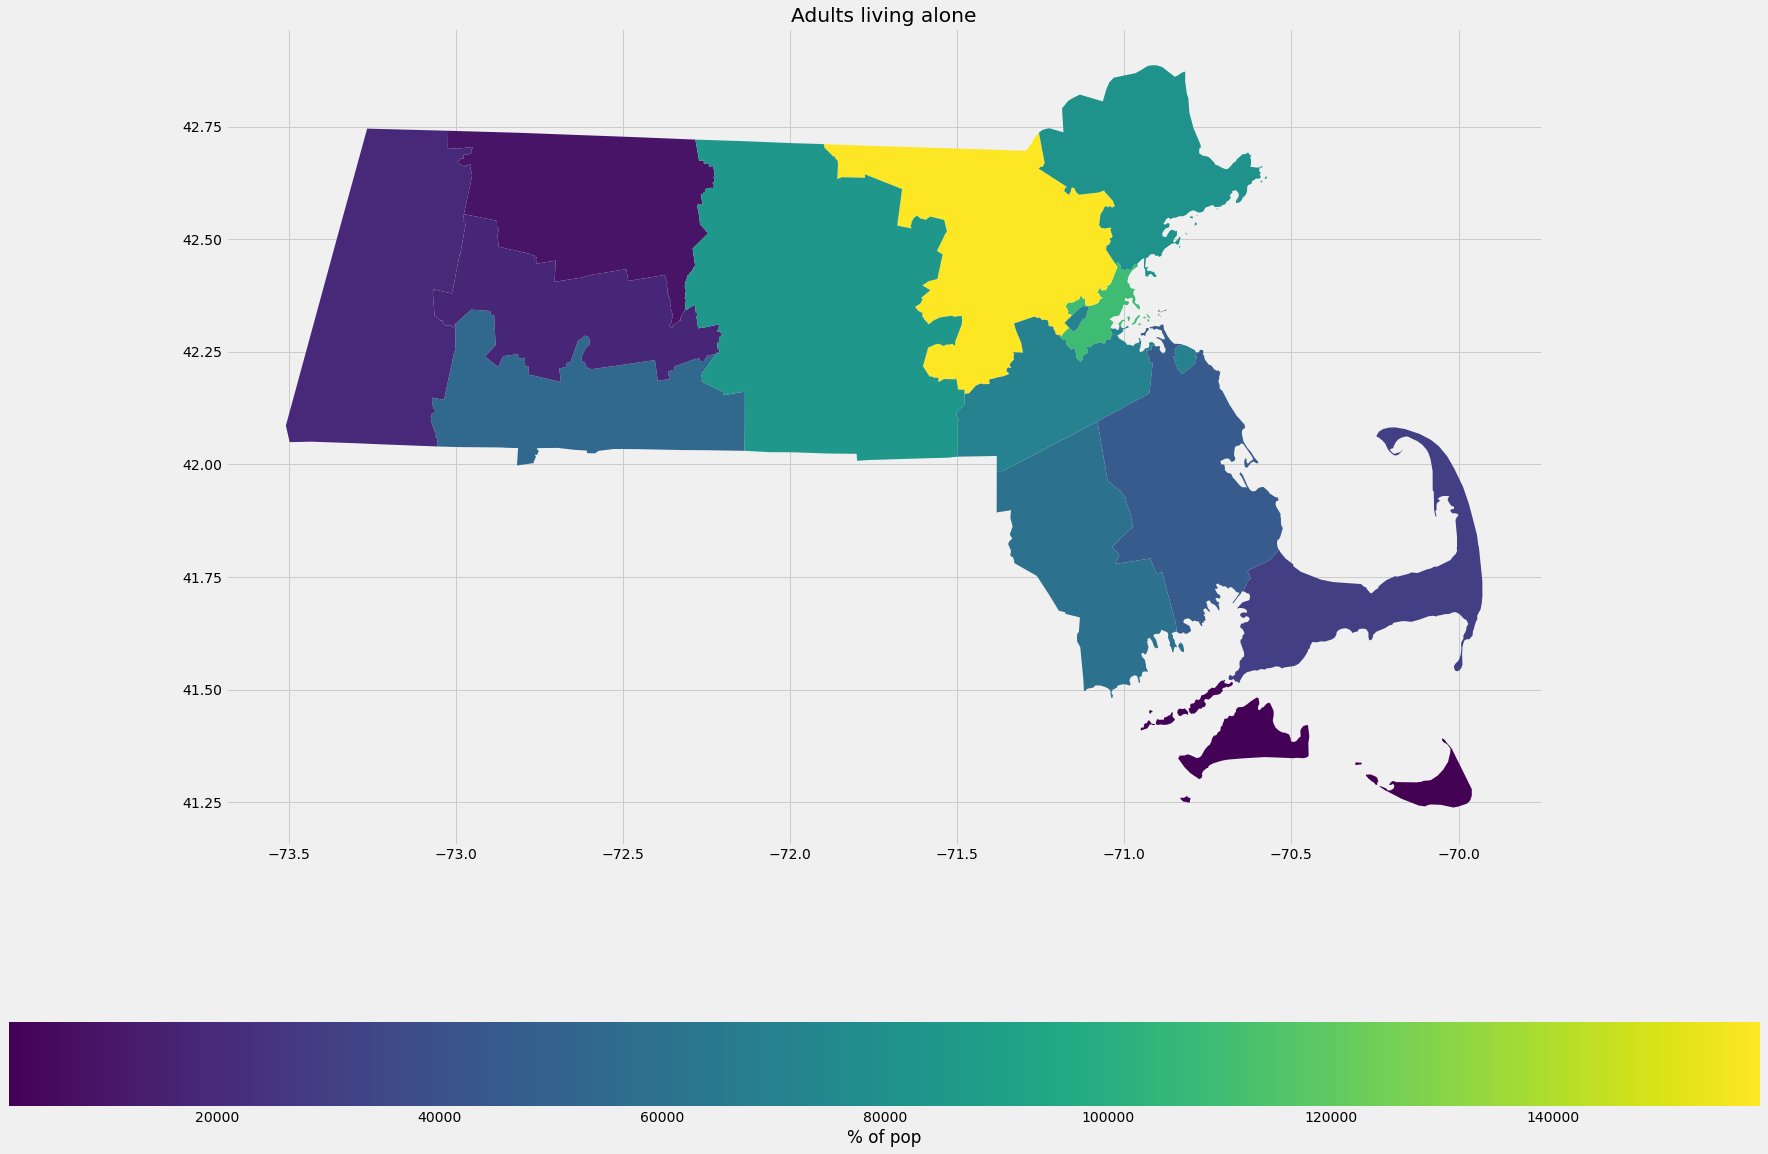

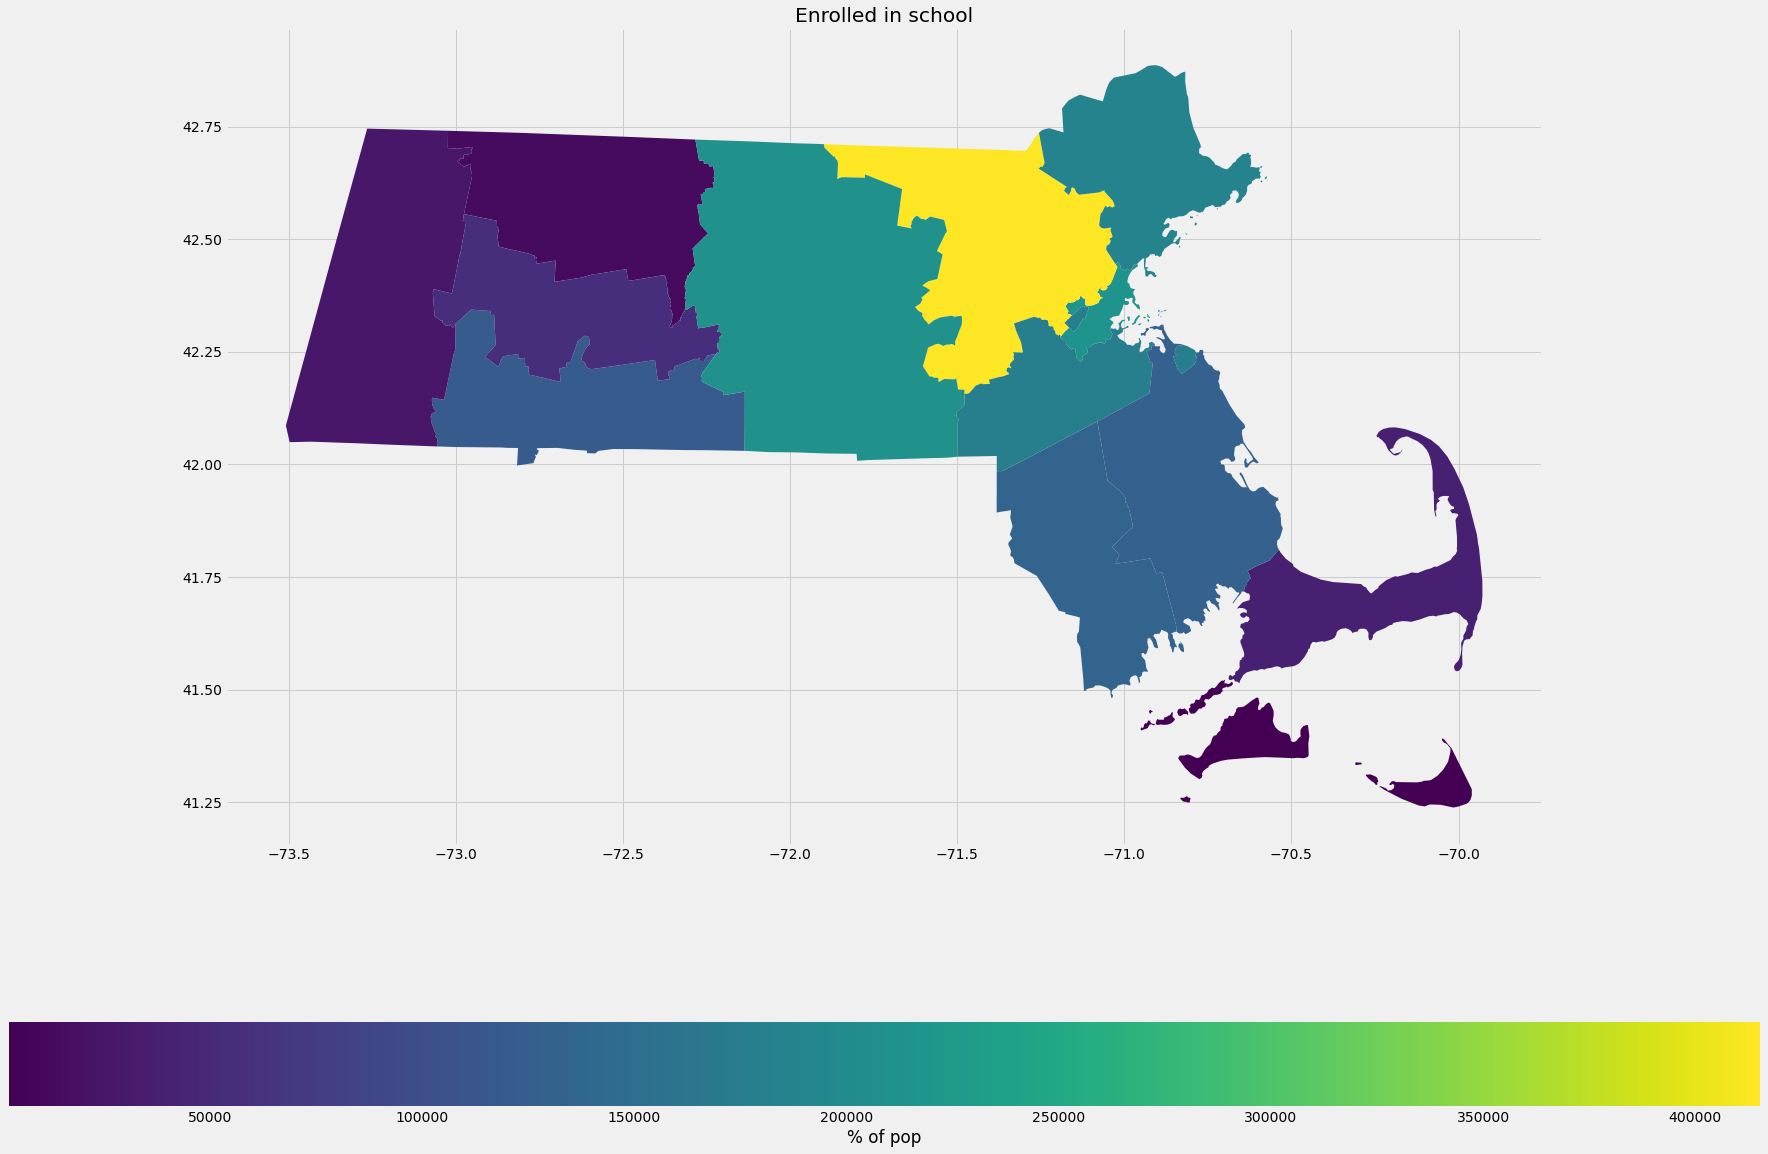

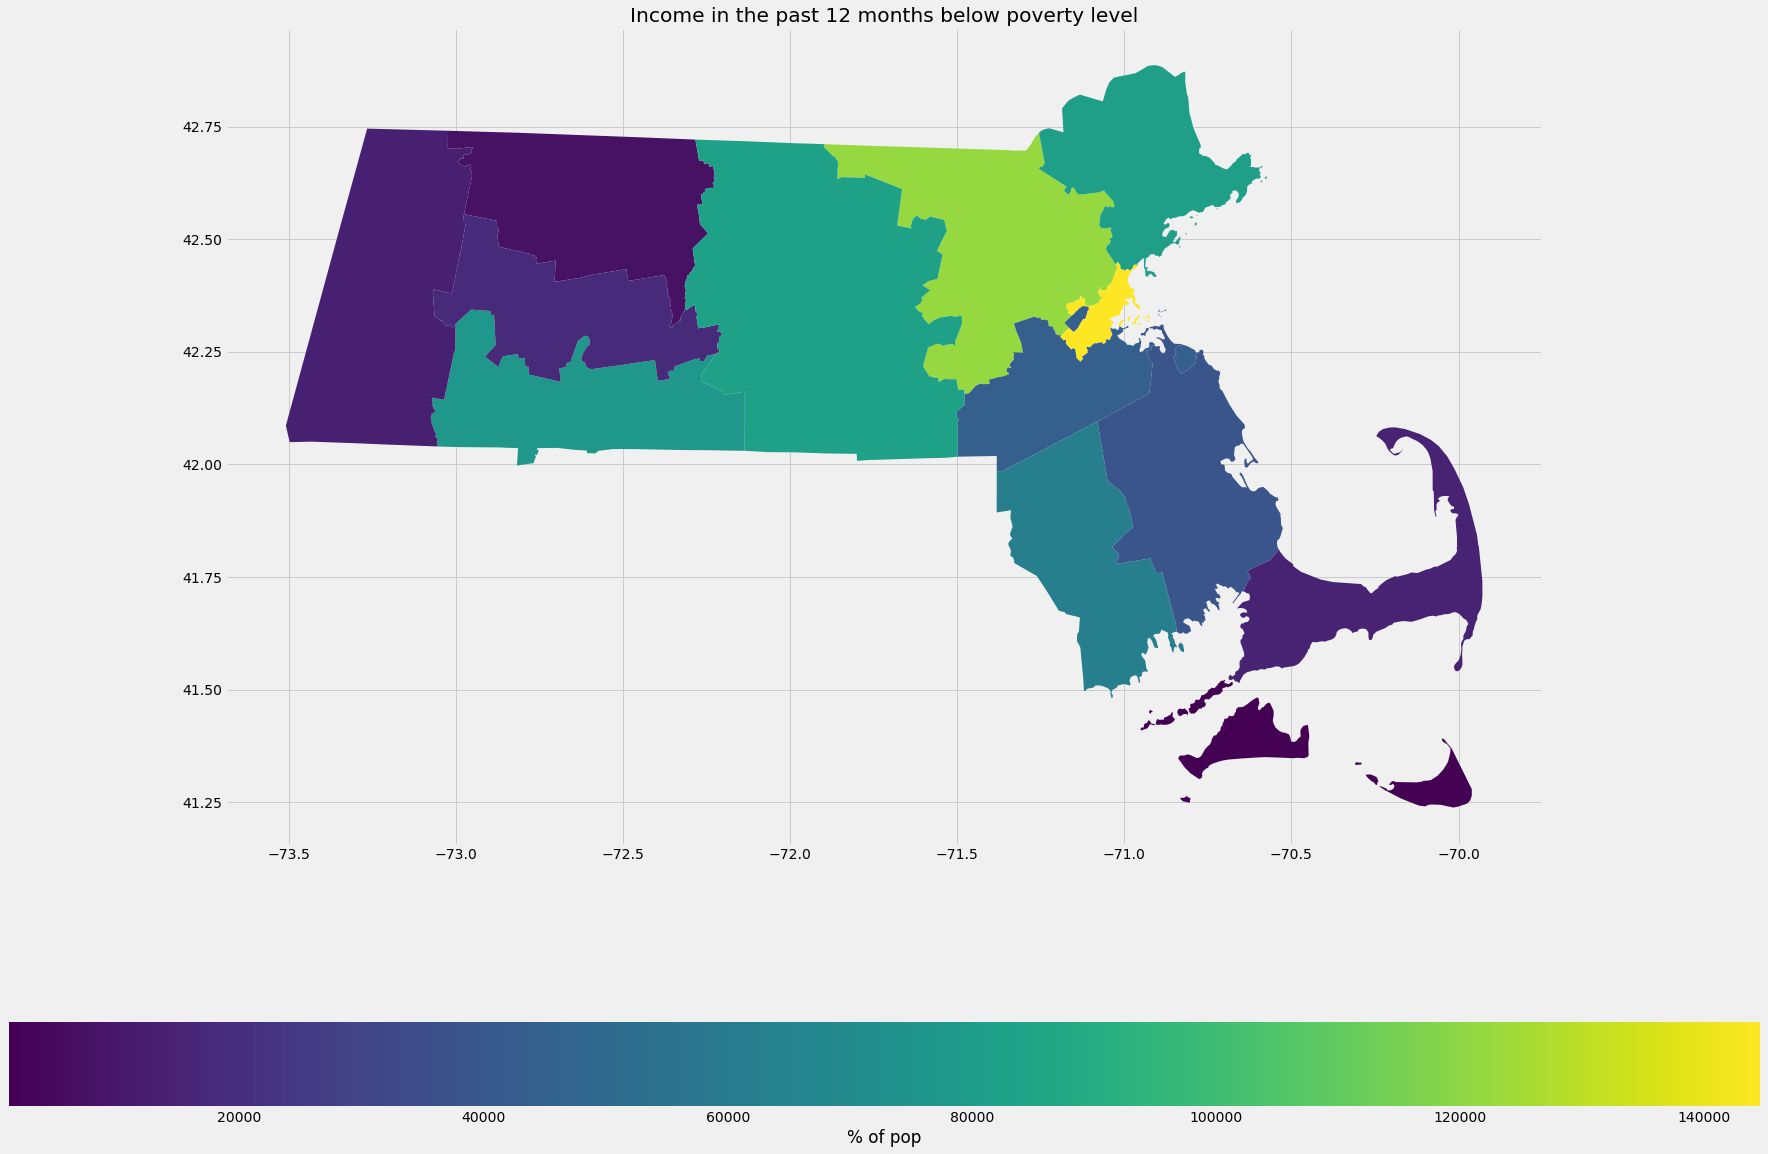

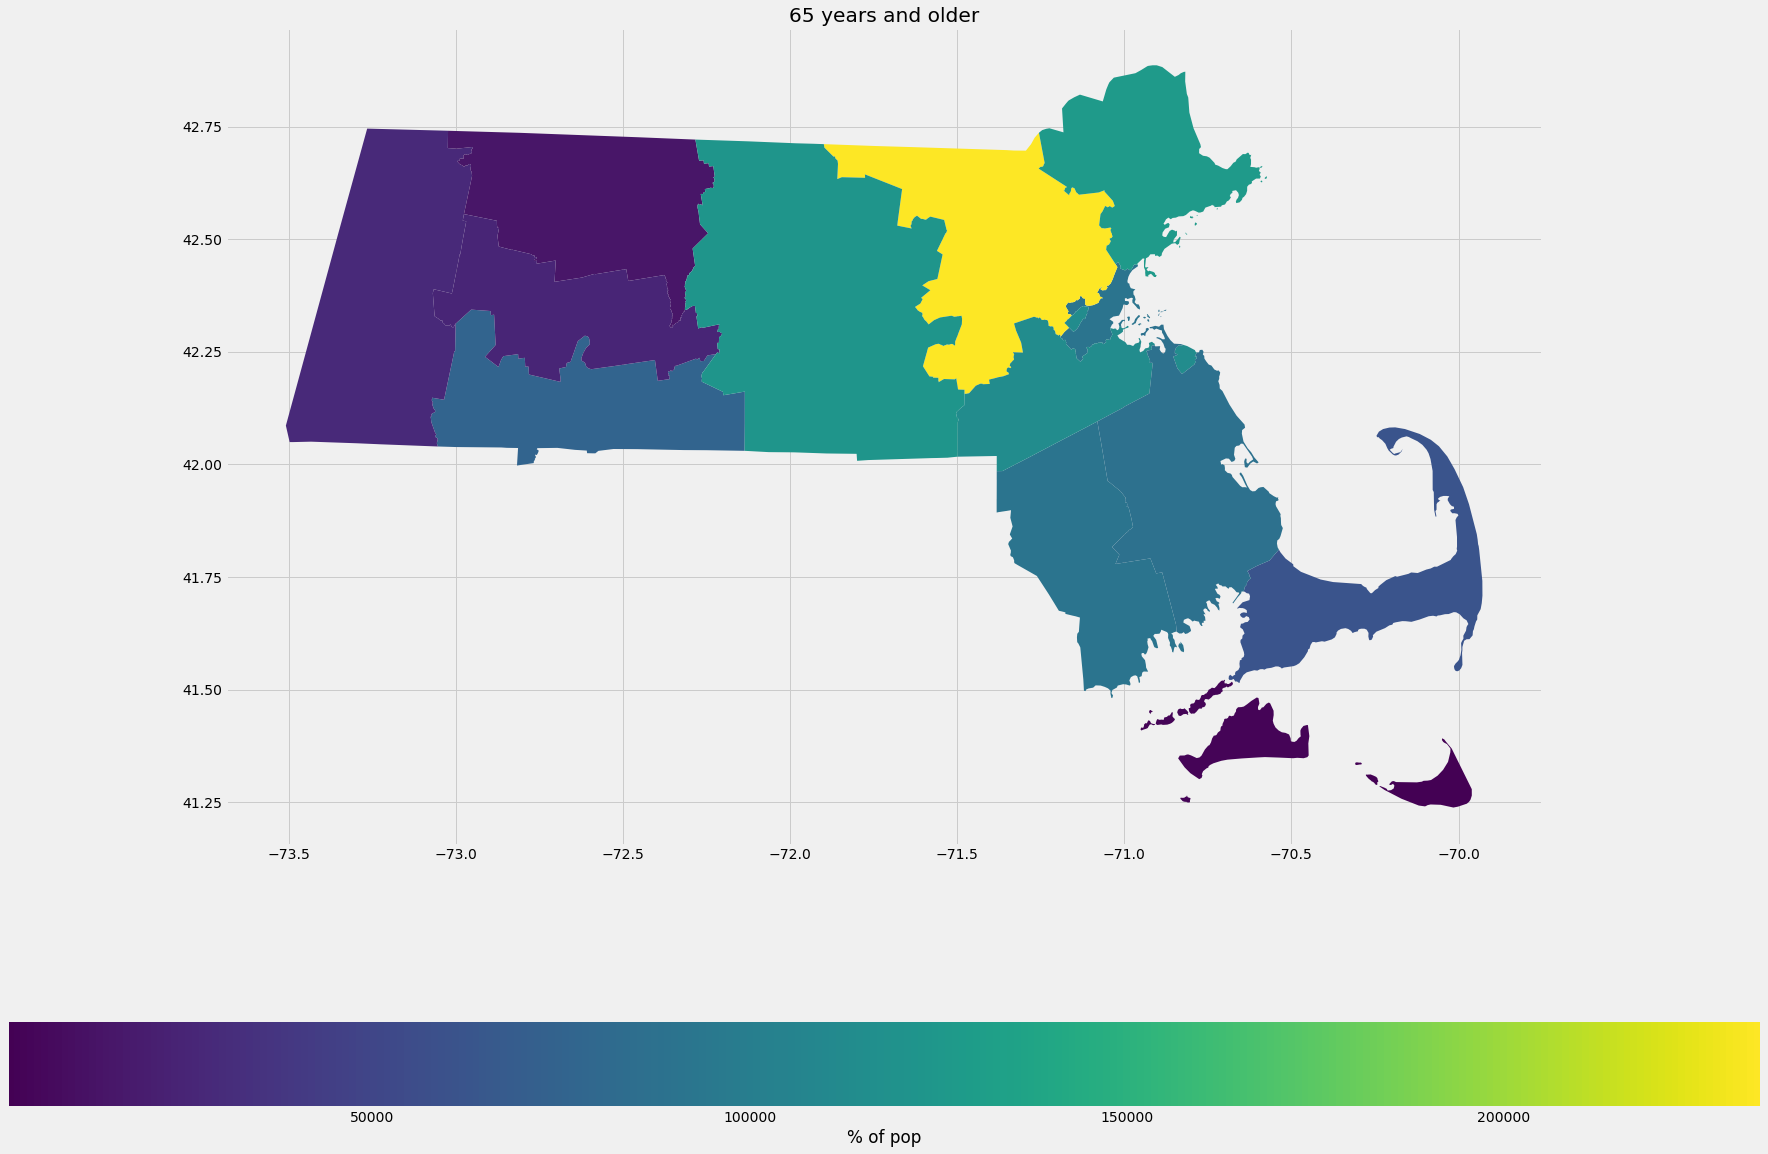

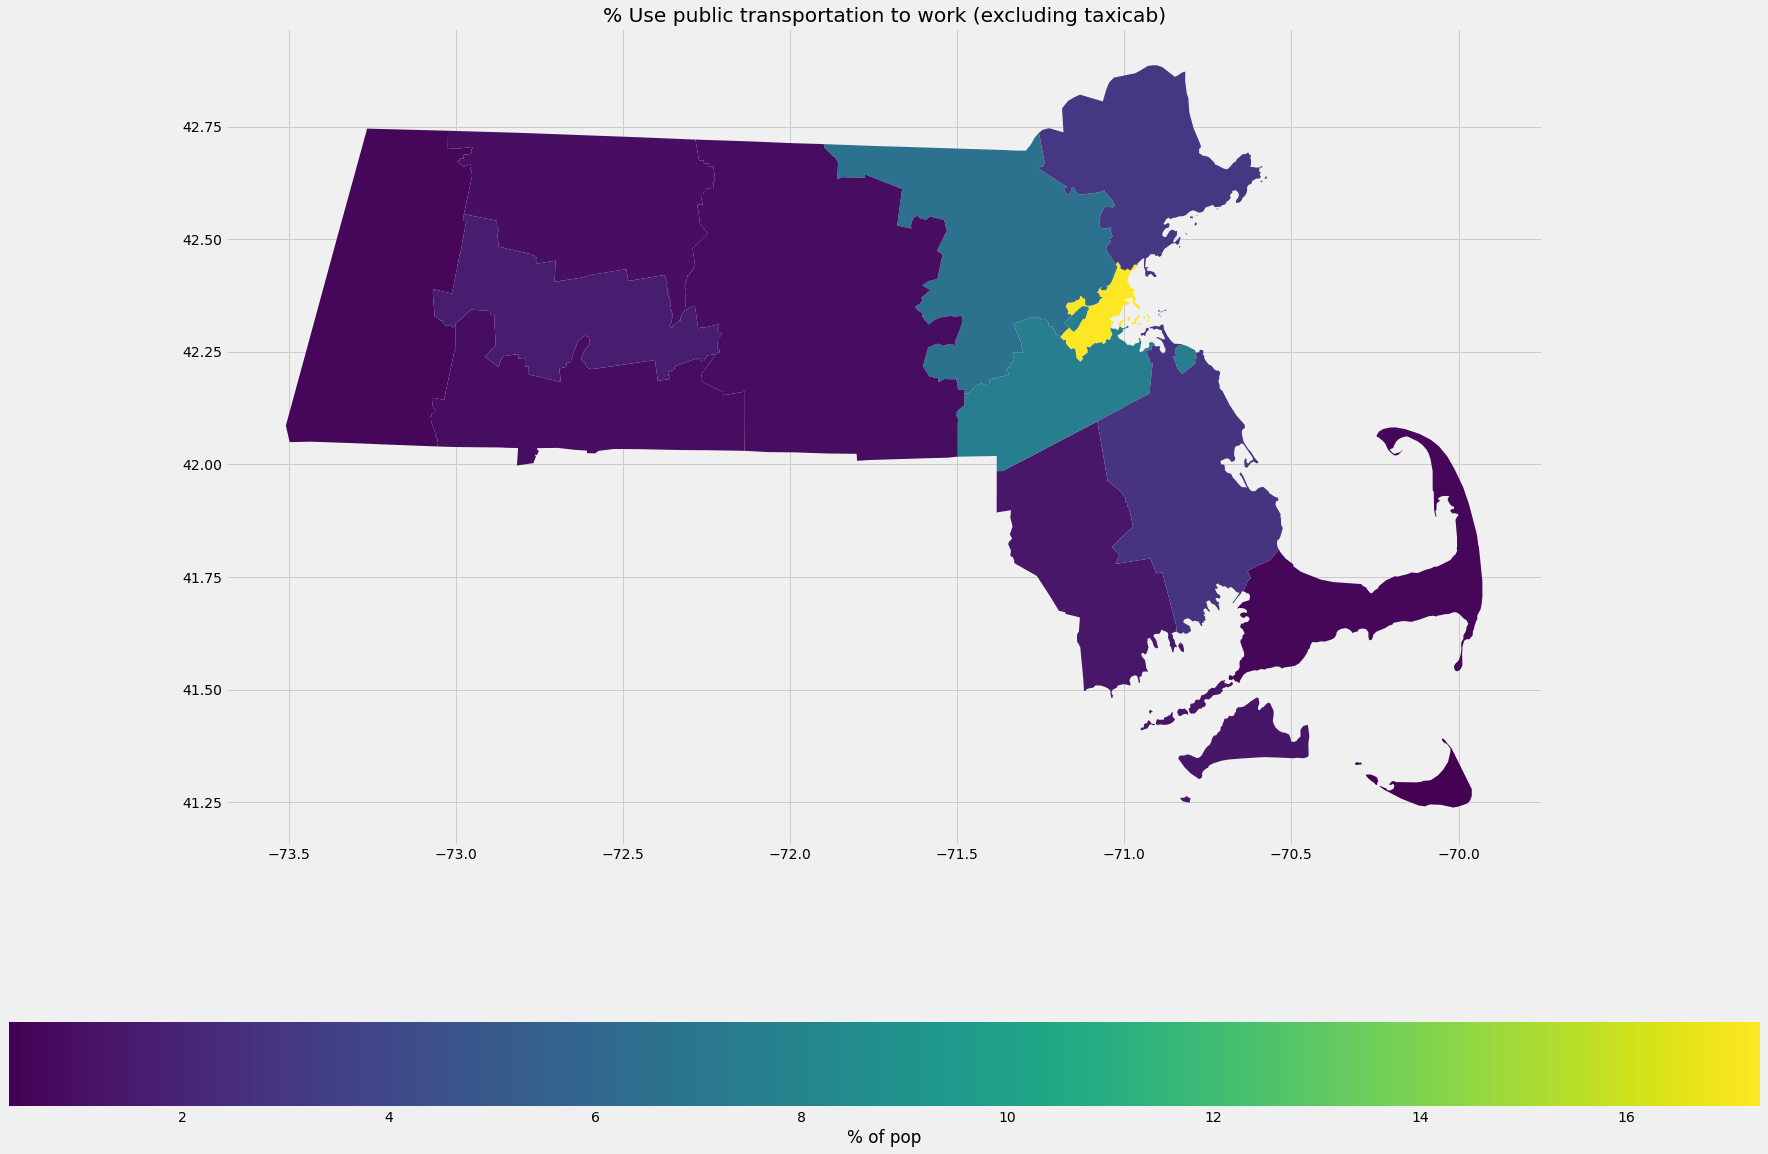

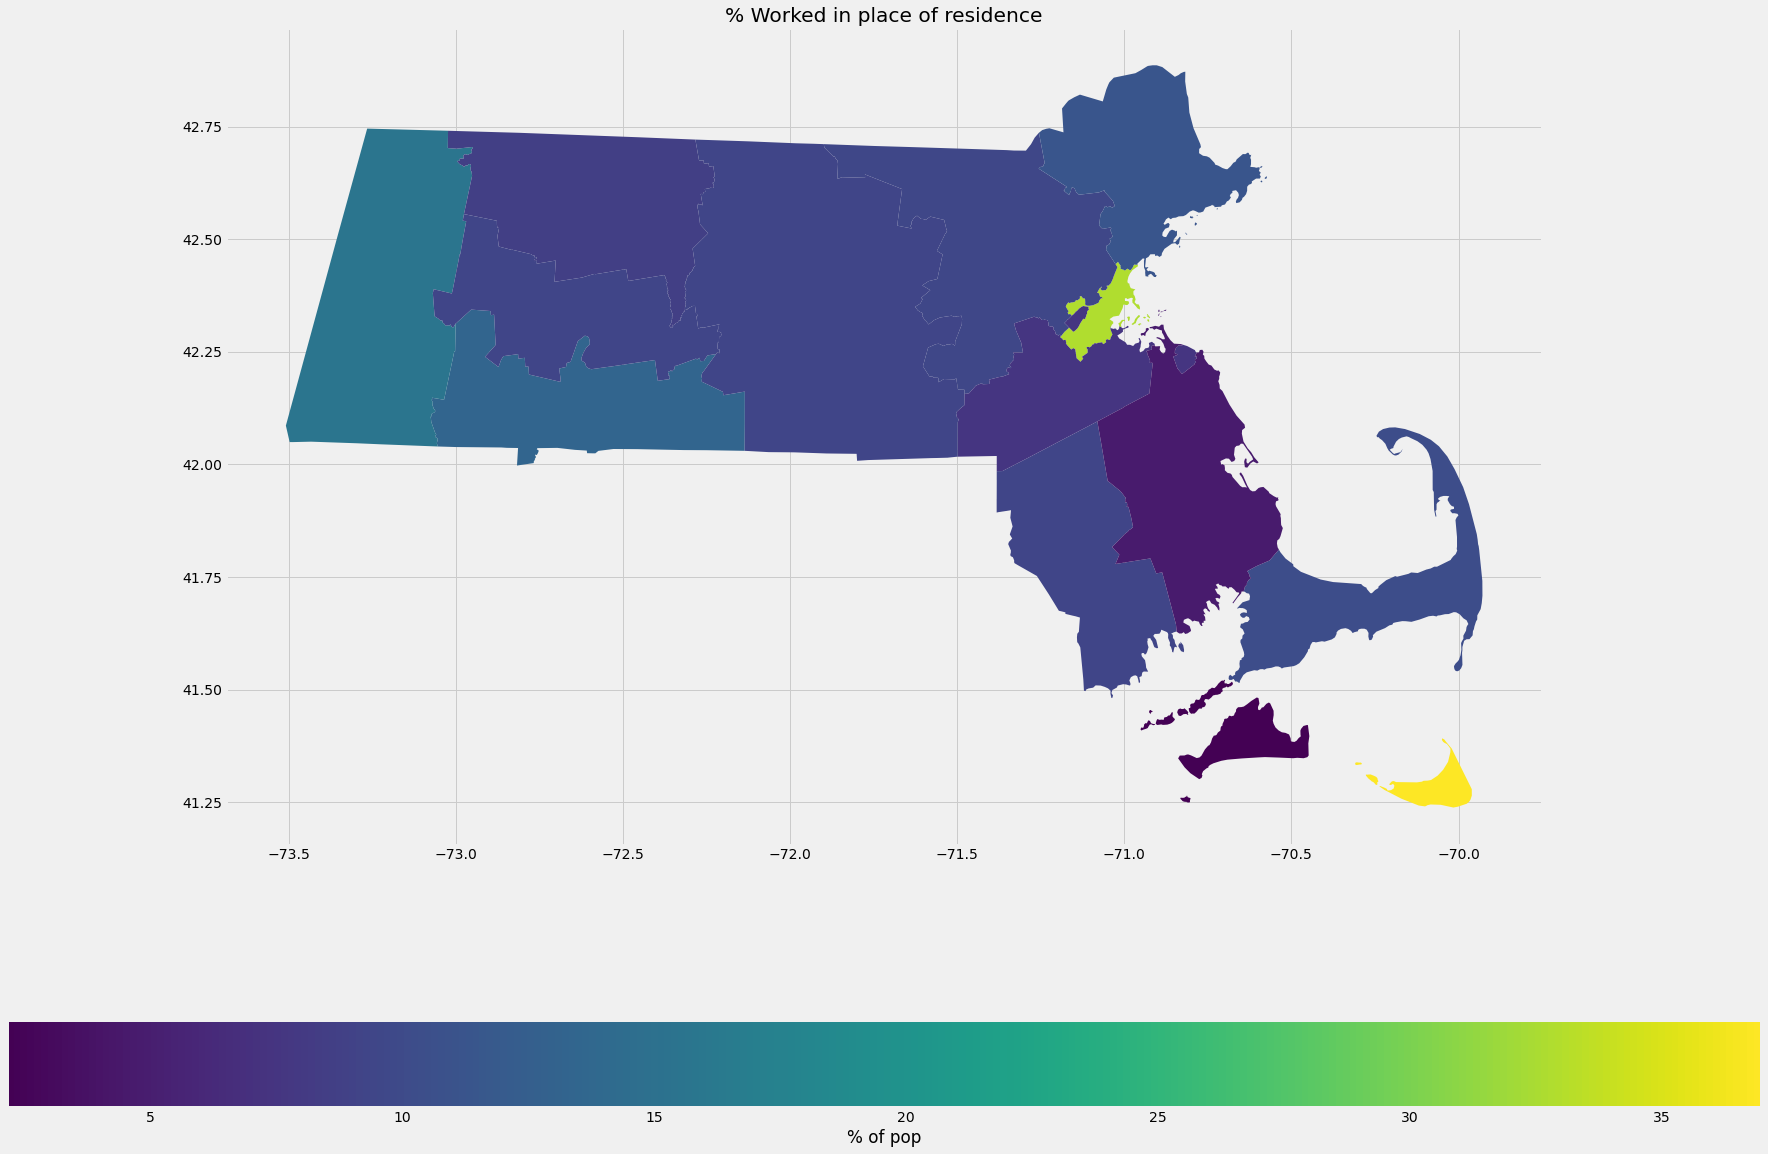

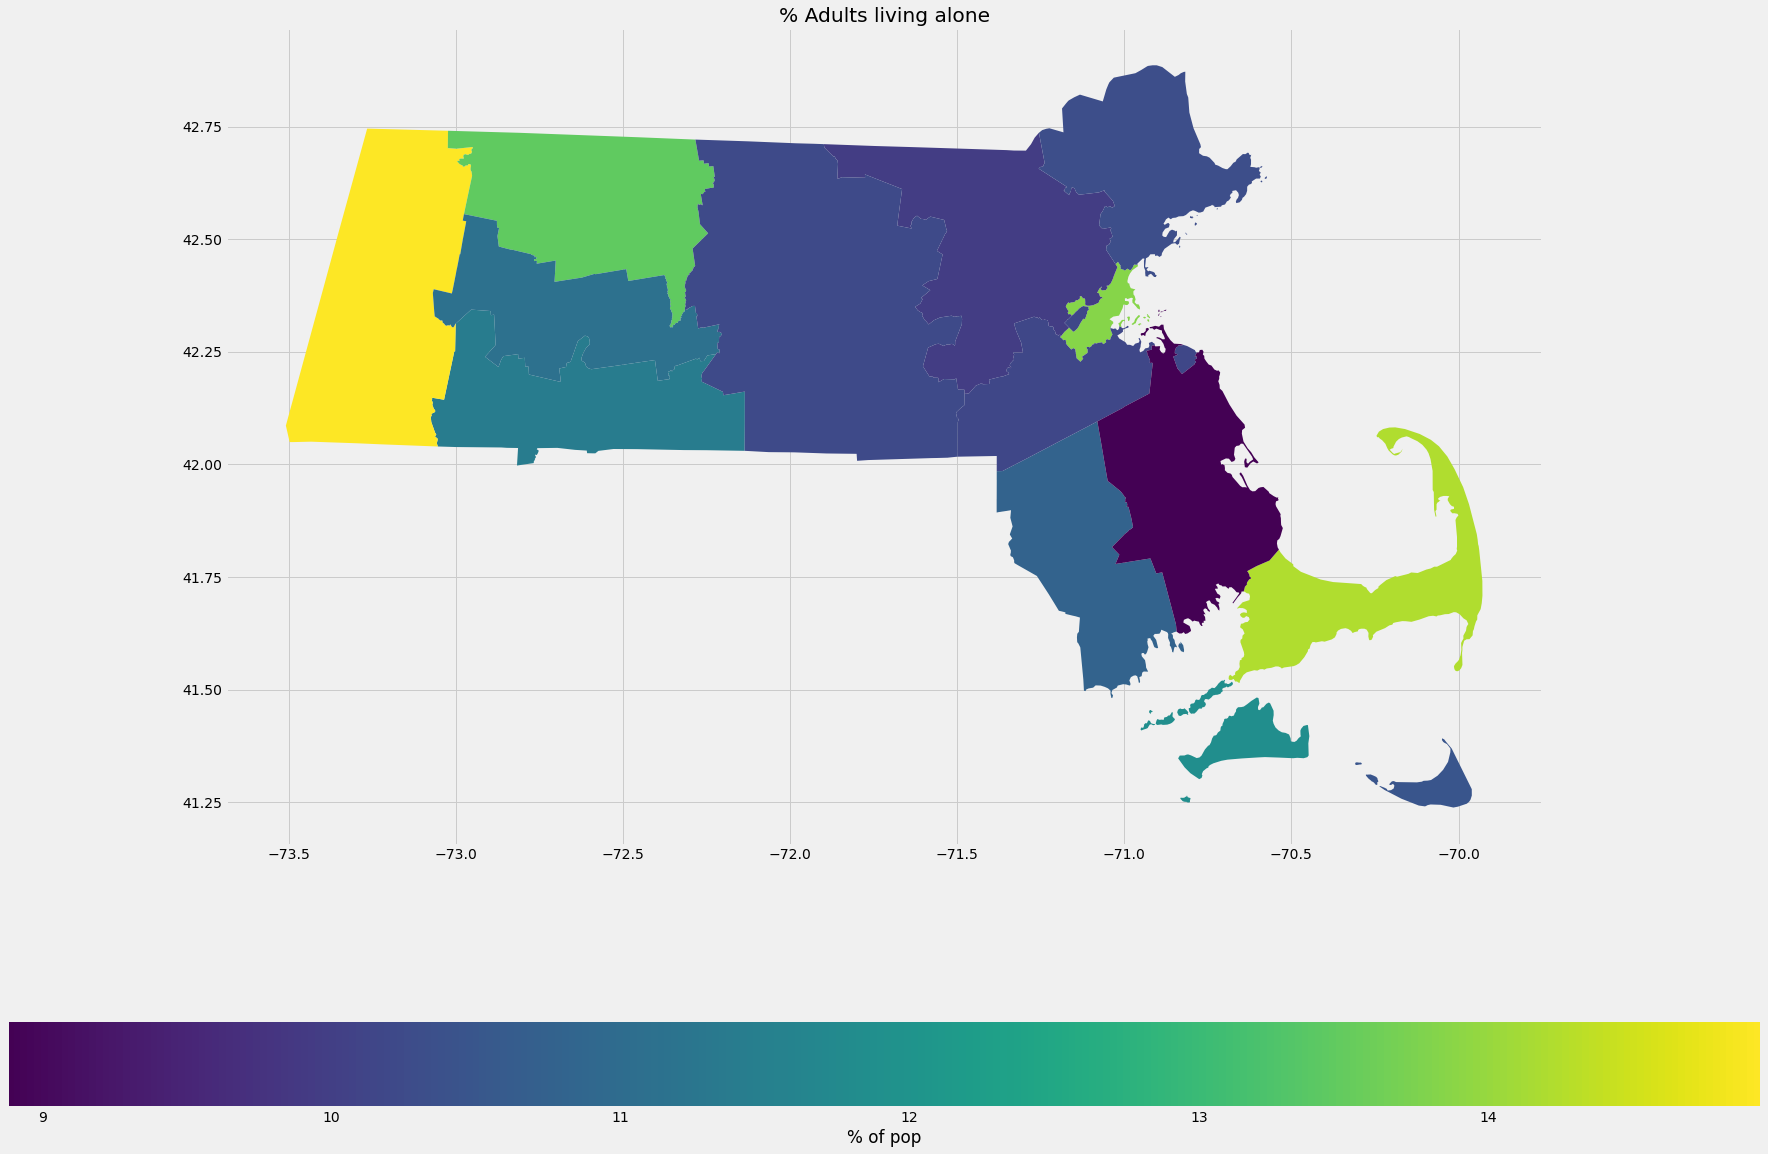

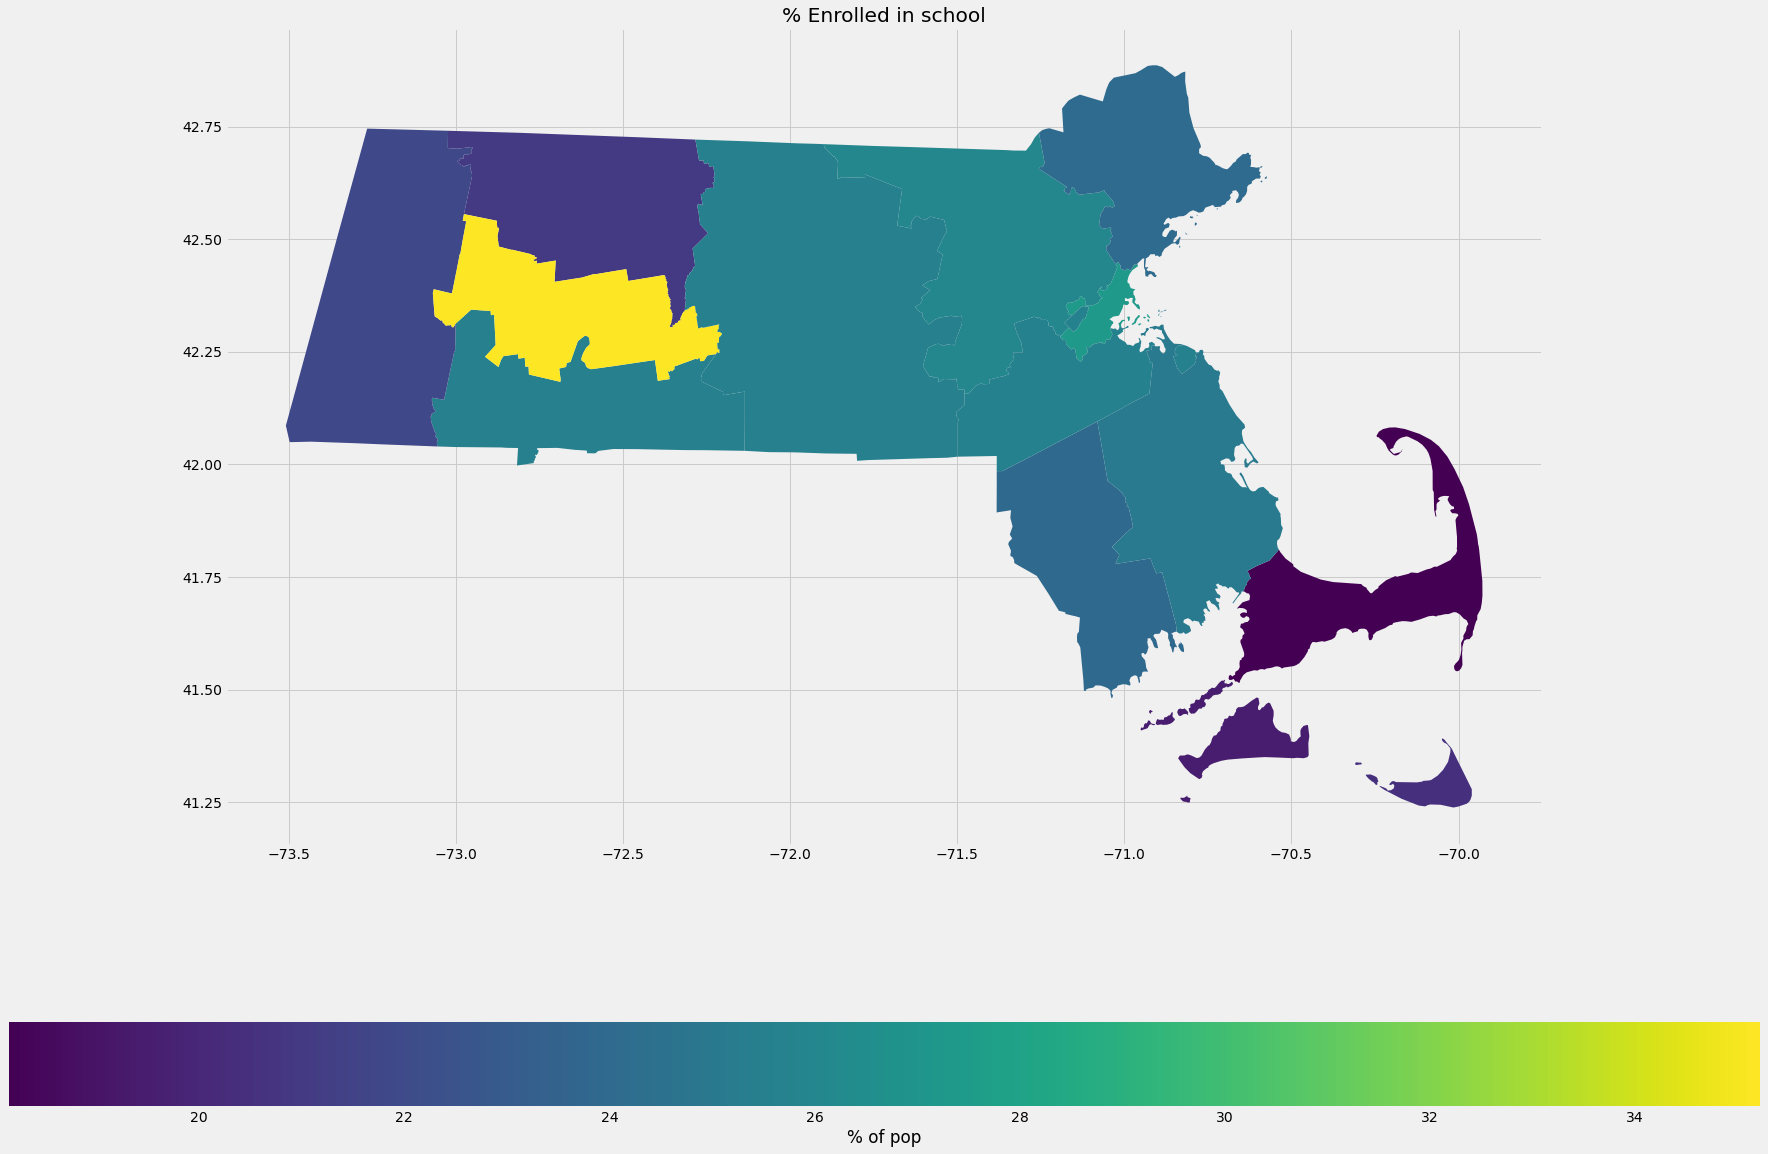

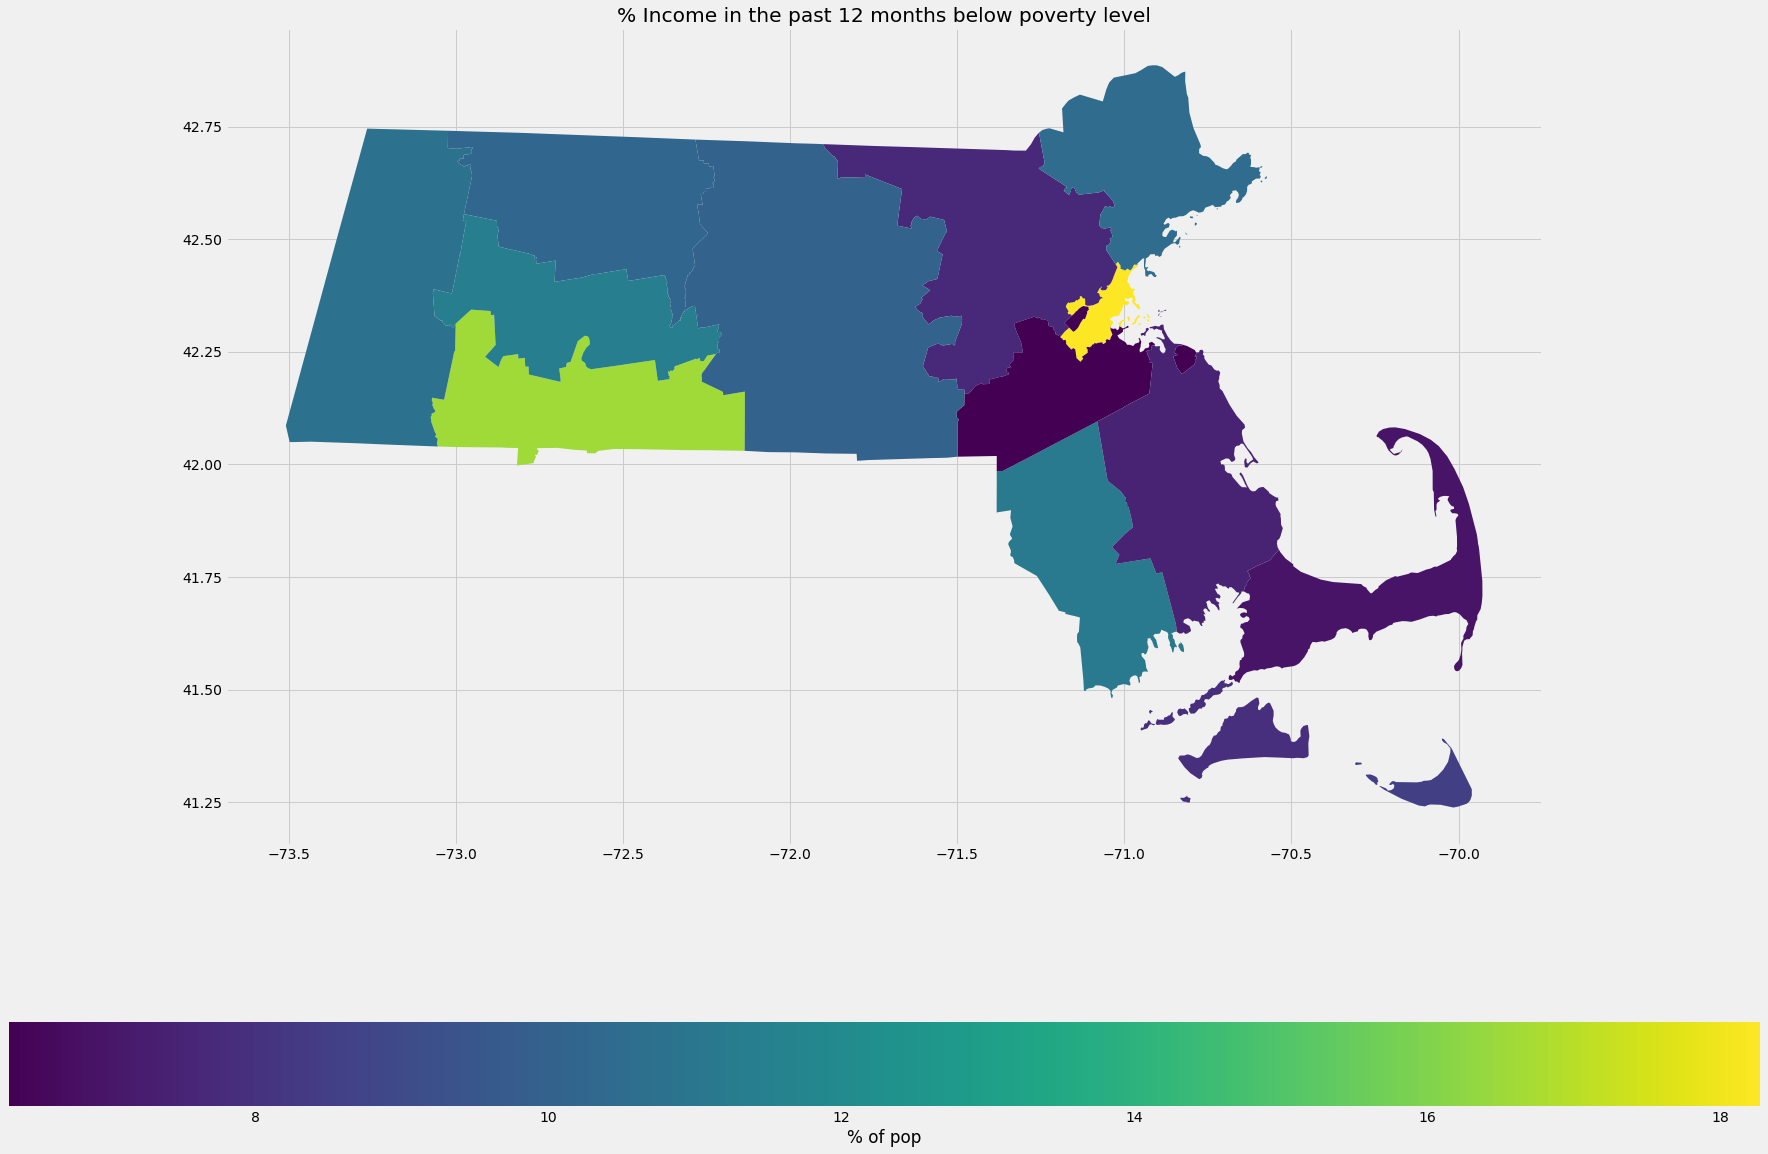

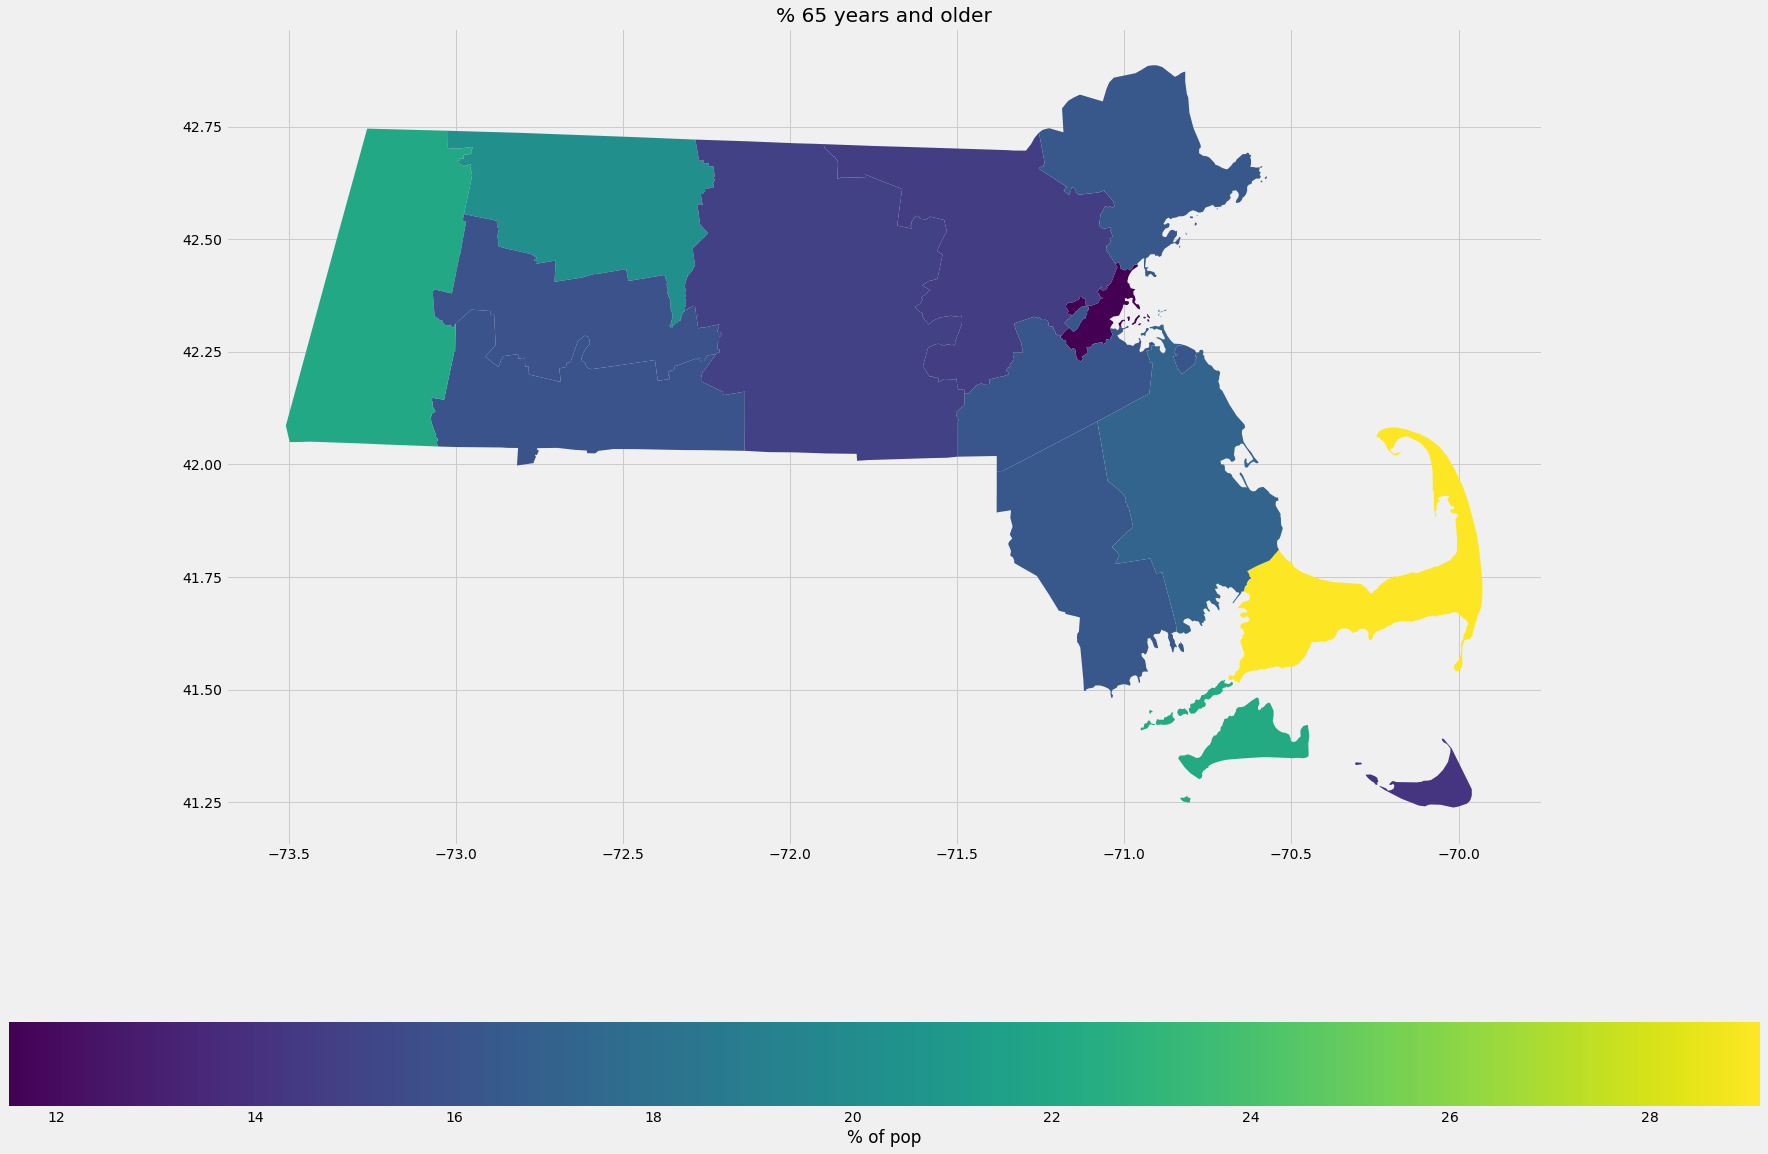

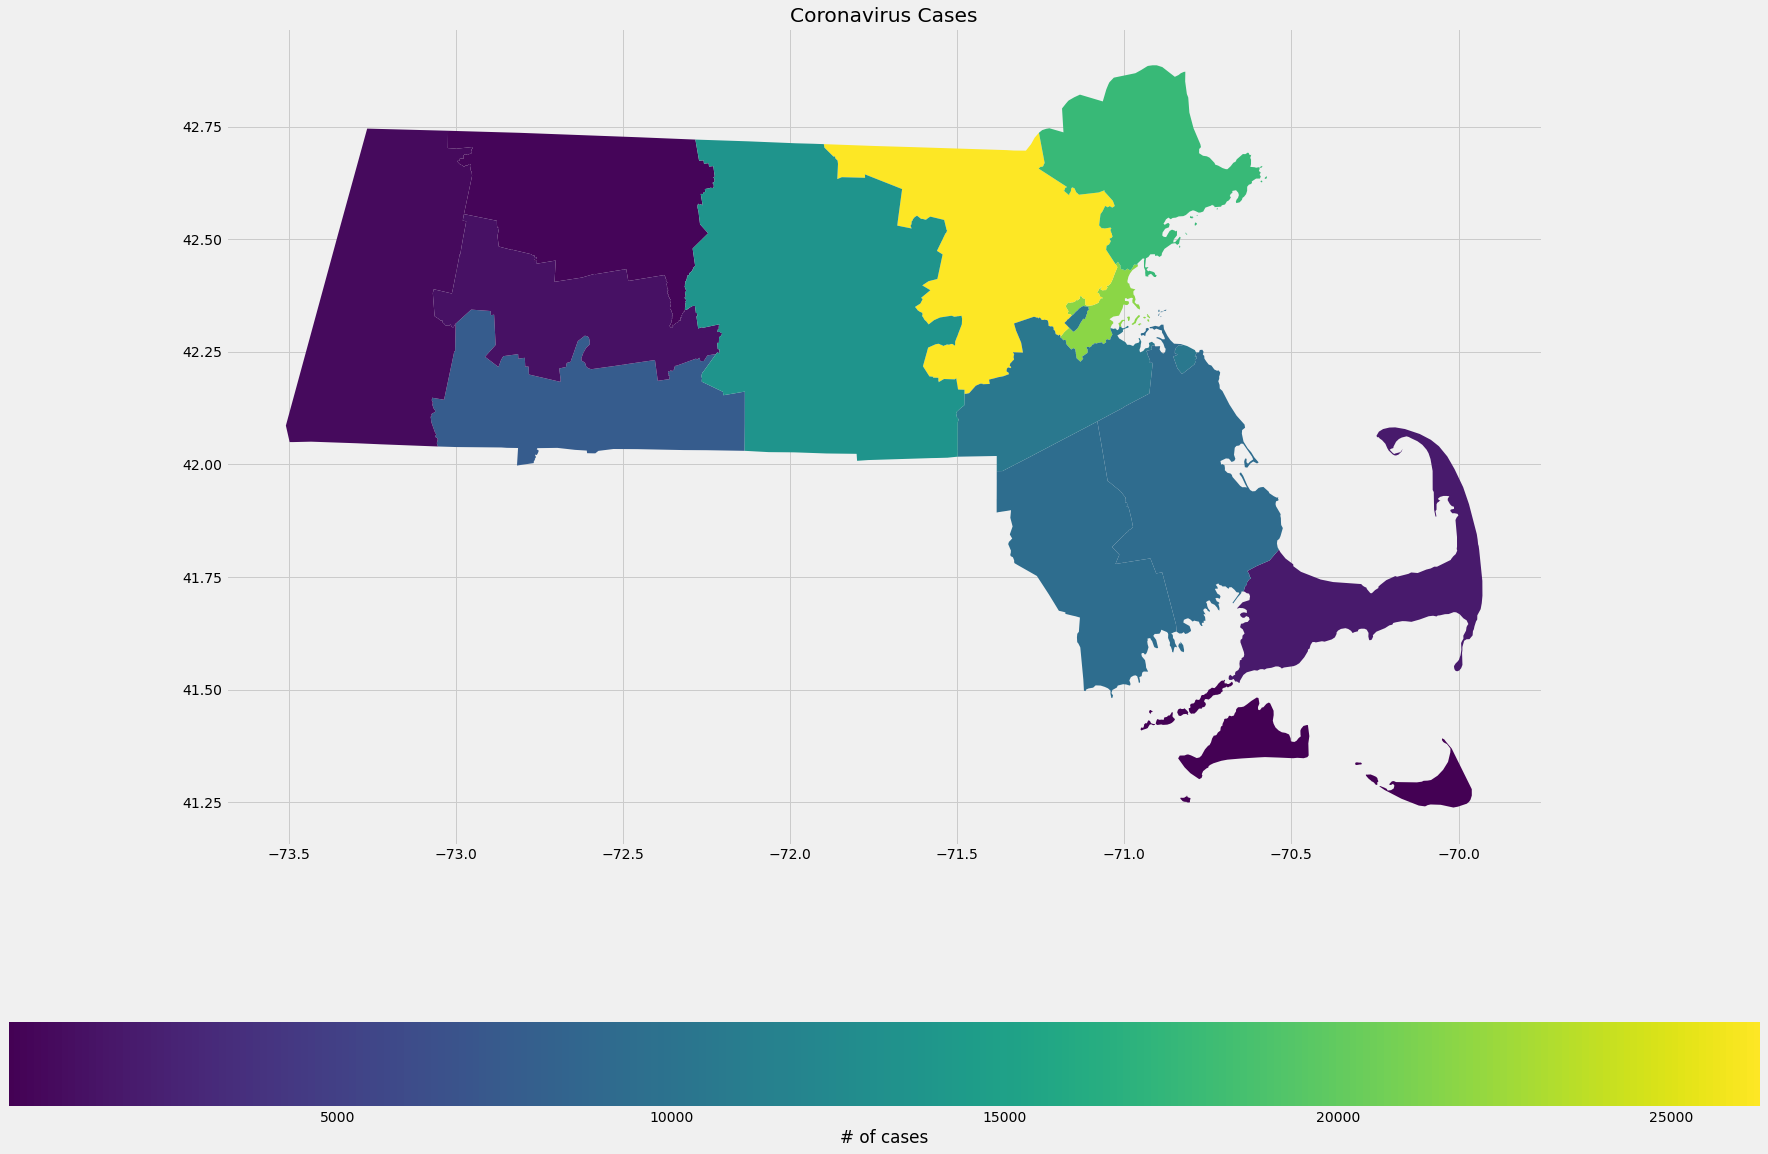

In [1]:
%run ./AI4DICensus.ipynb

## COVID Data + Census data  

In [2]:
census = gdf[['COUNTYFP','Population','% Use public transportation to work (excluding taxicab)','% Worked in place of residence','% Adults living alone','% 65 years and older']]

In [3]:
corona_csv = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
corona = {}
df = pd.read_csv(corona_csv, error_bad_lines=False, parse_dates=[0])

In [4]:
df_ma = df.loc[df['state']=='Massachusetts']

In [5]:
df_ma = df_ma[df_ma.county != 'Unknown']

In [6]:
df_ma['fips'] = df_ma['fips'].astype(int)

In [7]:
# for row in census.itertuples():
#     row.COUNTYFP = '25'+row.COUNTYFP
census['COUNTYFP'] = '25' + census['COUNTYFP'].astype(str)
census['COUNTYFP'] = census['COUNTYFP'].astype(int)
# print('25'+'0'+'25')

C:\Users\shubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\shubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [8]:
df_ma=df_ma.merge(census, how='outer', left_on='fips', right_on='COUNTYFP')
# census['COUNTYFP']

In [9]:
df_ma = df_ma.drop(['COUNTYFP','state','deaths'],axis = 1)
# df_ma = df_ma.drop('')

In [10]:
county_fips = pd.DataFrame({'county':['Suffolk', 'Dukes','Norfolk','Middlesex','Berkshire','Worcester','Essex','Barnstable','Bristol','Hampden','Plymouth','Franklin','Hampshire','Nantucket'], 
        'fips': [25025,25007,25021,25017,25003,25027,25009,25001,25005,25013,25023,25011,25015,25019] 
        })
df_ma.head()

,date,county,fips,cases,Population,% Use public transportation to work (excluding taxicab),% Worked in place of residence,% Adults living alone,% 65 years and older
0,2020-02-01,Suffolk,25025,1,791766.0,17.310544,32.819545,13.839316,11.50883
1,2020-02-02,Suffolk,25025,1,791766.0,17.310544,32.819545,13.839316,11.50883
2,2020-02-03,Suffolk,25025,1,791766.0,17.310544,32.819545,13.839316,11.50883
3,2020-02-04,Suffolk,25025,1,791766.0,17.310544,32.819545,13.839316,11.50883
4,2020-02-05,Suffolk,25025,1,791766.0,17.310544,32.819545,13.839316,11.50883


In [11]:
def growth(df,rowcounty):
    df_c = df.loc[df['fips'] == rowcounty]
    for i in range(0,len(df_c)):
        df.loc[df_c.index[i],'new_cases'] = df_c.iloc[i].cases-df_c.iloc[i-1].cases
    return df

In [12]:
def SHO(df,row,SHOdate):
#     delta.days
    delta =(pd.to_datetime(row.date) - pd.to_datetime(SHOdate))
    return delta.days 

In [13]:
def preprocessing(df,sortby,SHOdate):
    df.groupby(['date']).agg({'cases':sum})
    df=df.sort_values(sortby,ascending=True)
#     df=df[['date','county','fips', 'cases','deaths']]
    abc=list()
    SHOLIST=list()
    for row in df.itertuples():
        SHOLIST.append(SHO(df,row,SHOdate))
        if row.fips not in abc:
            abc.append(row.fips)
            growth(df,row.fips)
        else:
            continue
    
    df['stayhomeorder']=SHOLIST
#     (df_test['First_Date'] - df_test['Second Date']).dt.days
    df.set_index(['date'], inplace=True)
#     df.loc[SHOdate:,'stayhomeorder']=1
#     df.loc[:SHOdate,'stayhomeorder']=0
    return df

In [14]:
df_ma=preprocessing(df_ma,'date','2020-03-24')

In [15]:
# df_ma

In [16]:
df_ma['new_cases']=df_ma['new_cases'].astype('int64')
# print(df_ma.dtypes)

In [17]:
# df_ma.loc['2020-05-08']#[['county','fips']].loc['2020-05-02']#.unique()#.head()

In [18]:
def PL(df, label=None):
    PLevels = list()
    # MA
    polluted = [25003,25013,25025]
    for row in df.itertuples():
        if row.fips in polluted:
            PLevels.append(1)
        else:
            PLevels.append(0)
    return PLevels

In [19]:
#Mass
df_ma['pollutionlevels'] = PL(df_ma)

In [20]:
df_ma = df_ma.drop('county',axis = 1)

In [21]:
num = df_ma._get_numeric_data()

num[num < 0] = 1

## Feature Generation 

In [22]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
#     df['month'] = df['date'].dt.month
#     df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
#     df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['Population', 'pollutionlevels','stayhomeorder',
           '% Use public transportation to work (excluding taxicab)',
           '% Worked in place of residence', #'weather'
           '% 65 years and older','dayofweek','dayofmonth','fips']]
#             ,'month','dayofyear','weekofyear']] 
    if label:
        y = df[label]
        return X, y
    return X

## Prediction plots for each County 

In [23]:
def predictionplots(df):
    df=df.reset_index().merge(county_fips, how='inner', on='fips').set_index('date')
#     a.reset_index().merge(b, how="left").set_index('index')
    unifips=df['county'].unique()
    for i in unifips:
        df_f=pd.DataFrame()
        df_f=df[df.county==i]
#         df_f=df_f.set_index('date')
        _ = df_f[['new_cases','MA_Prediction']].plot(figsize=(10, 5), title=i)

In [24]:
def weekly(df):
    fip=list()
    for row in df.itertuples():
        if row.fips not in fip:
            fip.append(row.fips)
            df_c = df.loc[df['fips'] == row.fips]
#             for i in range(0,len(df_c)):
#                 df.loc[df_c.index[i],'new_cases'] = df_c.iloc[i].cases-df_c.iloc[i-1].cases
            df.groupby([pd.Grouper(key='date', freq='W-MON')])['MA_Prediction'].sum().reset_index().sort_values('date')
 
        else:
            continue
    
    return df

## XGBoost Model 

In [25]:
def Prediction(dfP,split_date,future_dates):
    color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
    _ = dfP.groupby(dfP.index)['new_cases'].sum().plot(figsize=(25,5), color=color_pal[0], title='MA cases')
#     _ = d.plot(figsize=(25,5), color=color_pal[0], title='MA cases')
    dfP_train = dfP.loc[dfP.index <= split_date].copy()
    dfP_test = dfP.loc[dfP.index > split_date].copy()
    X_train, y_train = create_features(dfP_train, label='new_cases')
    X_test, y_test = create_features(dfP_test, label='new_cases')
    x_test = create_features(future_dates)

    # XGBoost Model
    reg = xgb.XGBRegressor(booster='gbtree', max_depth=9,
    n_estimators=60, min_child_weight=2, 
    colsample_bytree=0.8, subsample=0.8,
    eta=0.5, seed=2)
    reg.fit(X_train, y_train, eval_metric="rmse", 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=4,
       verbose=False) # Change verbose to True if you want to see it train
    
    # plot feature importance
    _ = plot_importance(reg, height=0.9)
    

    #Forecast on Test Set
    dfP_test['MA_Prediction'] = reg.predict(X_test).astype(int)
    future_dates['MA_Prediction'] = reg.predict(x_test).astype(int)
    fd=future_dates.groupby(future_dates.fips)['MA_Prediction'].sum()
#     future_dates.append(weekly(future_dates))
#     future_dates=future_dates.groupby(['fips', pd.Grouper(key='date', freq='W-MON')])['MA_Prediction'].sum().reset_index().sort_values('date')
    dfP_all = pd.concat([dfP_train, dfP_test], sort=True)
 
    plt.figure()
    
    Predict_ma = dfP_all[['fips','new_cases','MA_Prediction']].loc[split_date:]#.plot(figsize=(15, 5))
    PMA=dfP_all[['fips','new_cases','MA_Prediction']]
    predictionplots(PMA)
    
    return future_dates,fd, Predict_ma

## Creating Database to predict a day ahead 

In [26]:
add_dates = [[df_ma.index[-1] + DateOffset(days=x) for x in range(1,2)]*14, [df_ma['fips'].unique()]]
# add_dates.append(fips)

In [27]:
fips=[]
fips=add_dates[1]

In [28]:
future_dates=pd.DataFrame()
fdf = []
future_dates['date'] = add_dates[0]
future_dates['fips'] = ''
for i in fips[0]:
#     fips.append()
    fdf.append(i) 

In [29]:
# future_dates
future_dates['fips']=fdf

In [30]:
def futurePredictions(df):
    addate = [[df.date.iloc[-1] + DateOffset(days=x) for x in range(1,2)]*14, [df_ma['fips'].unique()]]
#     print('in futurePredictions')
    FD=pd.DataFrame()
    FD['date'] = addate[0]
    FD['fips'] = fdf
    return FD

In [31]:
for _ in range(6):
    future_dates=future_dates.append(futurePredictions(future_dates),ignore_index=True)

In [32]:
# def do():
#     future_dates.append(futurePredictions(future_dates),ignore_index=True)

In [33]:
# future_dates.groupby(dfP.index)['new_cases'].sum()

In [34]:
future_dates

,date,fips
0,2020-08-09,25025
1,2020-08-09,25021
2,2020-08-09,25017
3,2020-08-09,25003
4,2020-08-09,25027
...,...,...
93,2020-08-15,25023
94,2020-08-15,25011
95,2020-08-15,25015
96,2020-08-15,25019


In [35]:
future_dates=future_dates.merge(census, how='outer', left_on='fips', right_on='COUNTYFP')

In [36]:
FSHOLIST=[]
for row in future_dates.itertuples():
    FSHOLIST.append(SHO(future_dates,row,'2020-03-24'))
future_dates['stayhomeorder']=FSHOLIST
future_dates=future_dates.set_index('date')
future_dates=future_dates.sort_values('date',ascending=True)

In [37]:
future_dates['pollutionlevels'] = PL(future_dates)
x_test = create_features(future_dates)

In [38]:
# future_dates
# x_test
# df_ma.dtypes

## Predicting from April 20th 

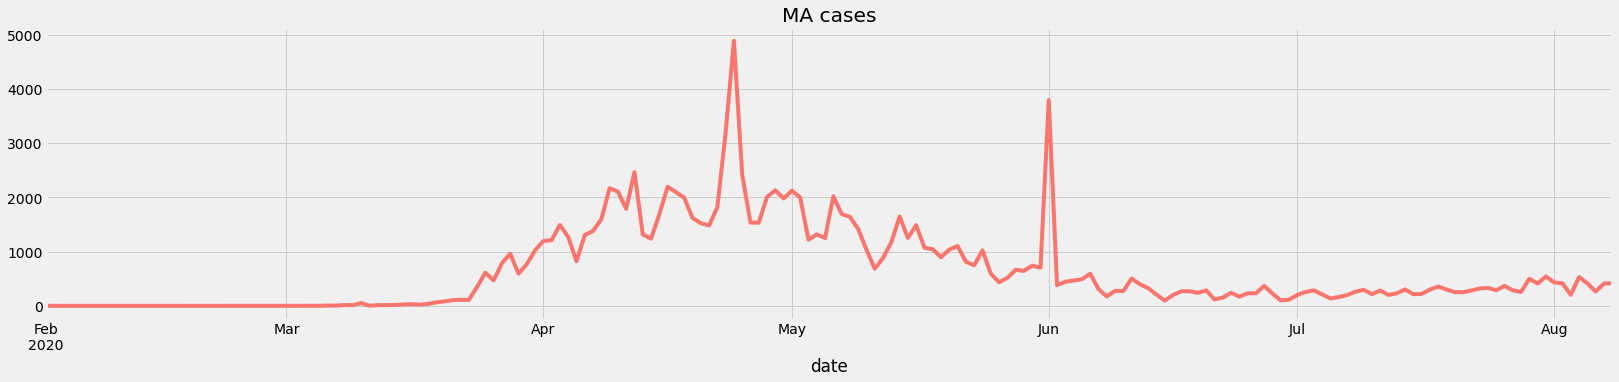

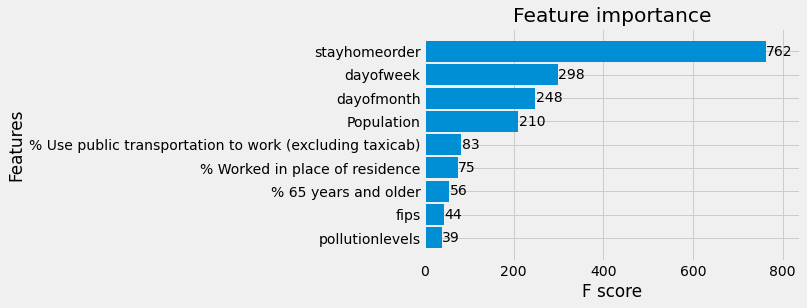

<Figure size 432x288 with 0 Axes>

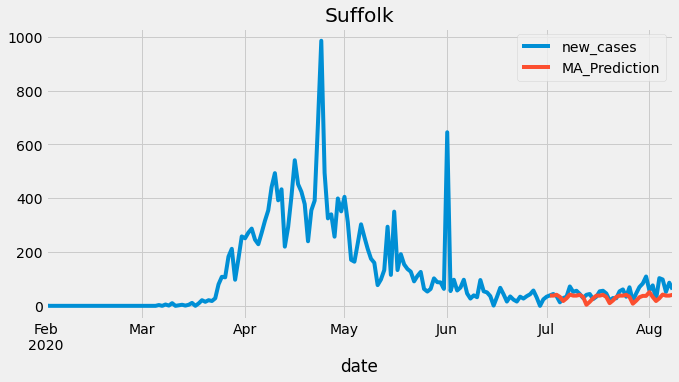

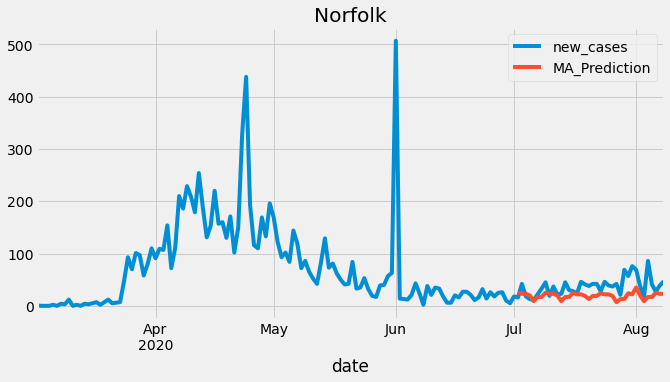

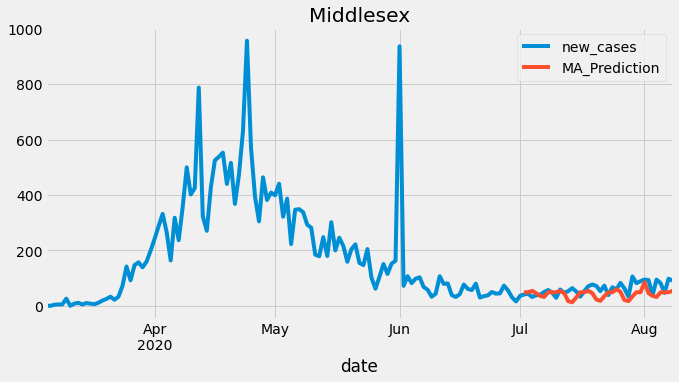

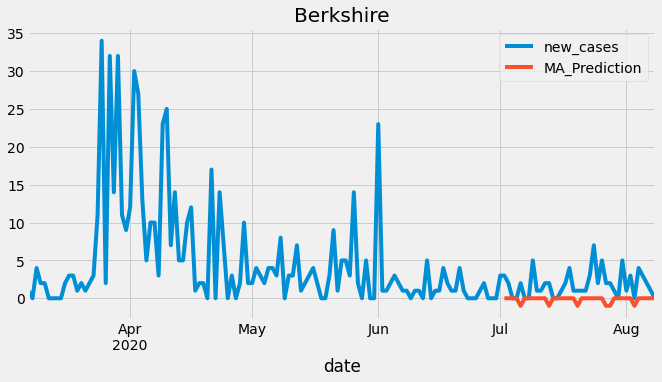

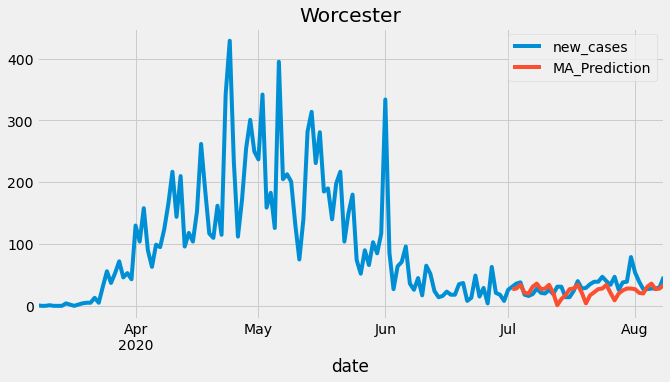

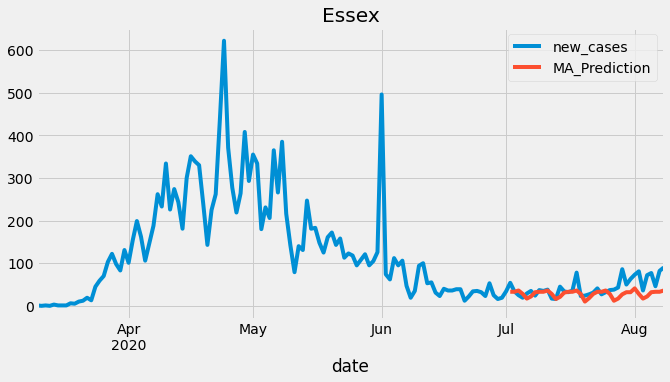

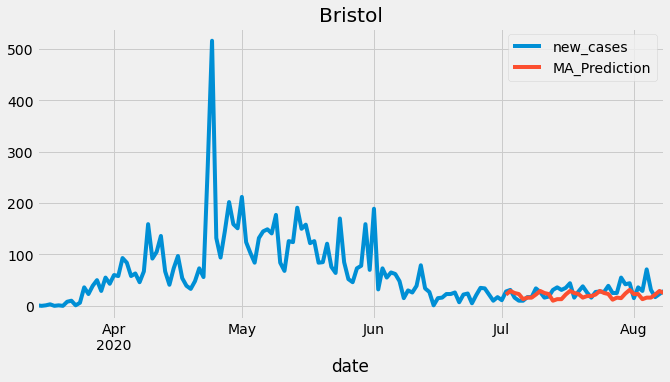

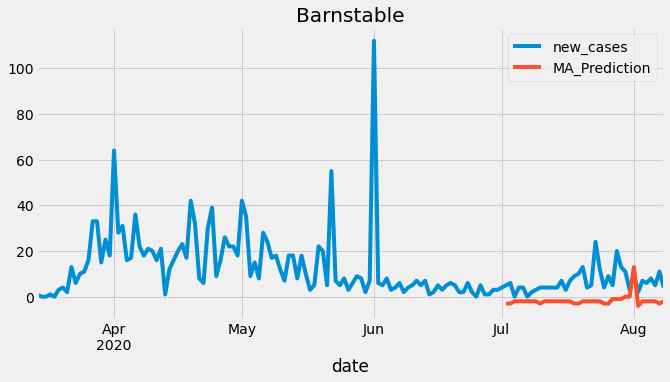

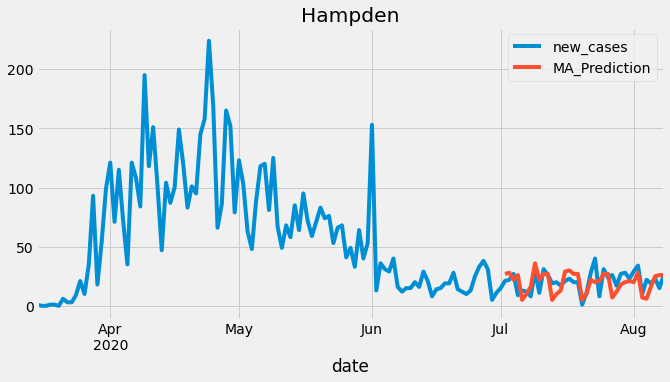

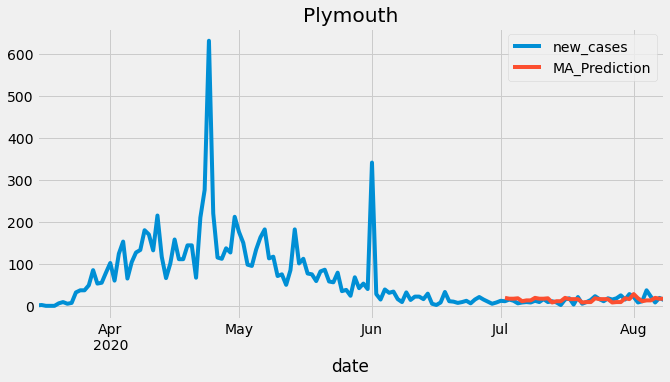

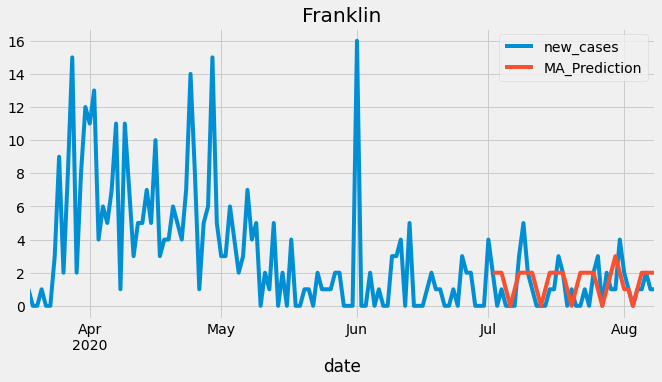

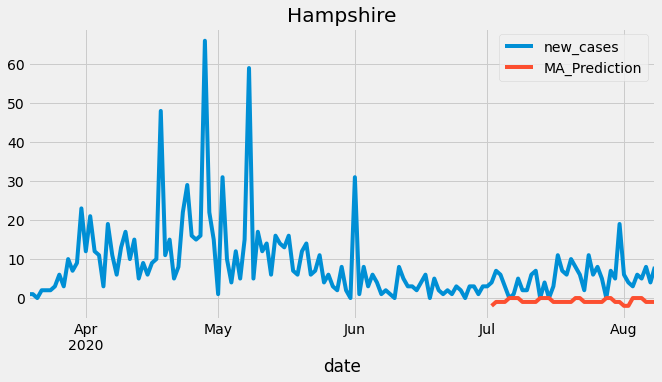

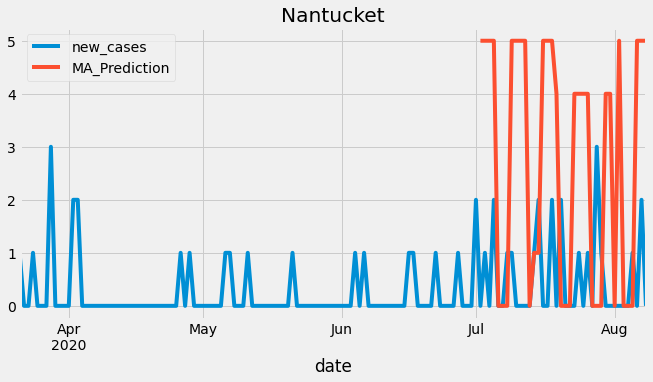

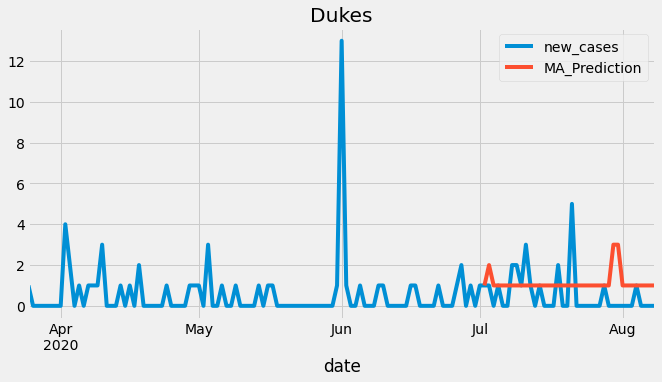

In [39]:
pre=Prediction(df_ma.loc['2020-02-01':],'2020-07-01',future_dates)

In [40]:
pre[2].loc['2020-07-01':]#.MA_Prediction

,fips,new_cases,MA_Prediction
date,,,
2020-07-01,25003,3,NaN
2020-07-01,25017,36,NaN
2020-07-01,25011,4,NaN
2020-07-01,25019,2,NaN
2020-07-01,25007,1,NaN
...,...,...,...
2020-08-08,25017,91,54.0
2020-08-08,25021,47,23.0
2020-08-08,25019,0,5.0


C:\Users\shubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\shubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\shubh\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

(             fips  COUNTYFP  Population  \
 date                                      
 2020-08-09  25025     25025    791766.0   
 2020-08-09  25027     25027    822280.0   
 2020-08-10  25025     25025    791766.0   
 2020-08-10  25027     25027    822280.0   
 2020-08-11  25025     25025    791766.0   
 2020-08-11  25027     25027    822280.0   
 2020-08-12  25025     25025    791766.0   
 2020-08-12  25027     25027    822280.0   
 2020-08-13  25027     25027    822280.0   
 2020-08-13  25025     25025    791766.0   
 2020-08-14  25025     25025    791766.0   
 2020-08-14  25027     25027    822280.0   
 2020-08-15  25027     25027    822280.0   
 2020-08-15  25025     25025    791766.0   
 
             % Use public transportation to work (excluding taxicab)  \
 date                                                                  
 2020-08-09                                          17.310544         
 2020-08-09                                           0.875979         
 2020-

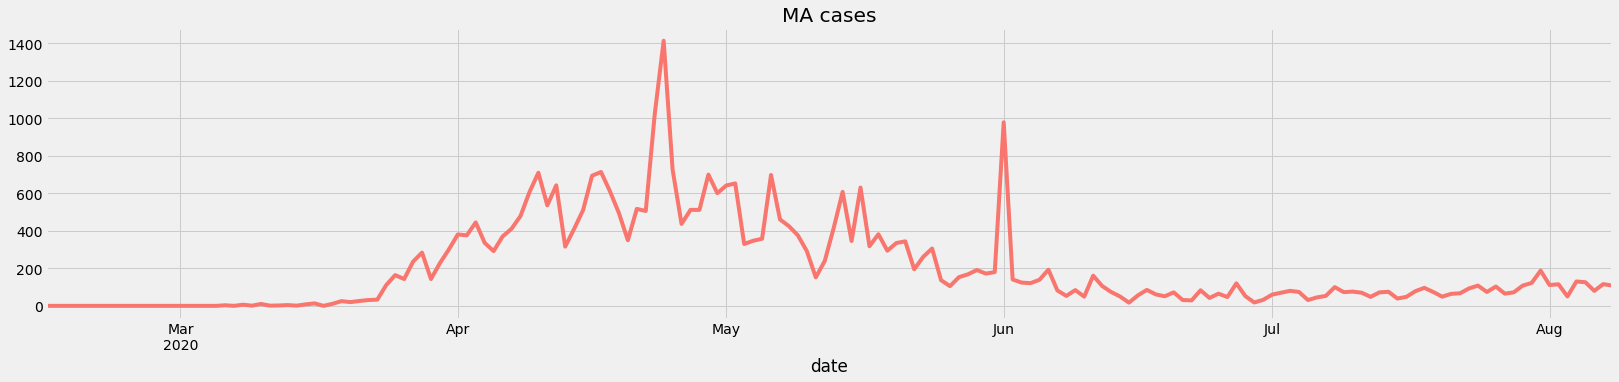

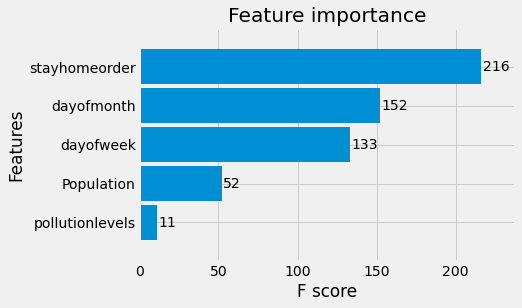

<Figure size 432x288 with 0 Axes>

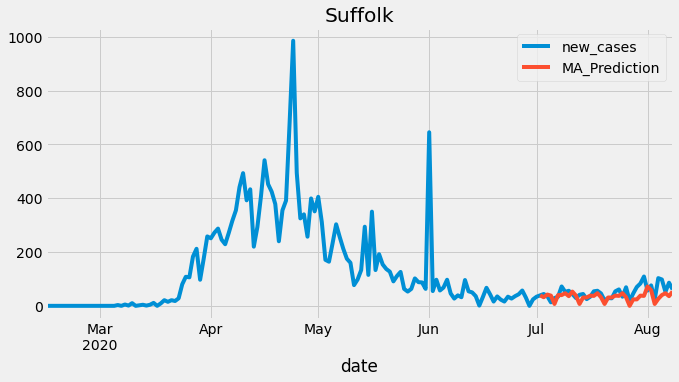

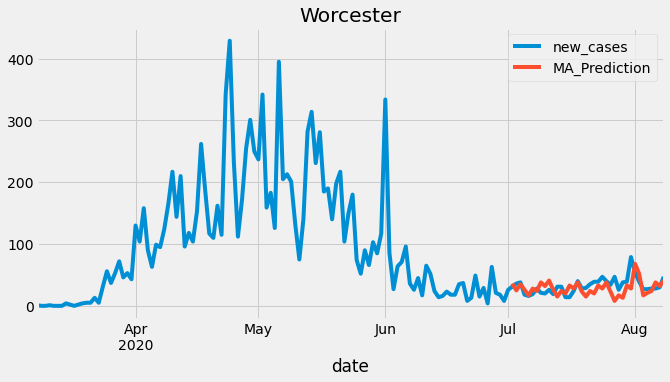

In [41]:
## For 2 Counties 
Prediction(df_ma[df_ma.fips>25024].loc['2020-02-15':],'2020-07-01',future_dates[future_dates.fips>25024])